In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#CREAZIONE GRAFICO SULLE PRIME 22 DIAGNOSI CON PIU PAZIENTI AFFETTI
############################################################################################
# Raggruppa per la colonna 'Description' e conta il numero di pazienti in ogni gruppo
df = pd.read_csv("Excel/Diagnostics.csv")
grouped = df.groupby('Description').size()

# Ordina i dati in ordine decrescente
top_22_descriptions = grouped.sort_values(ascending=False).head(22)

fig, ax = plt.subplots(figsize=(12,8))

# disegna il barplot
sns.barplot(
    x=top_22_descriptions.index,
    y=top_22_descriptions.values,
    hue=top_22_descriptions.index,
    palette="viridis",
    legend=False,
    ax=ax
)



# prendi le etichette originali, applica wrapping ogni 15 caratteri
wrapped = top_22_descriptions.index.to_series().str.wrap(55)

# impostale sull'asse x, con rotazione
ax.set_xticks(range(len(wrapped)))
ax.set_xticklabels(wrapped, rotation=45, ha='right')
ax.set_ylabel('Numero di pazienti', fontsize=16)
ax.set_xlabel('')  # niente label orizzontale

# Etichette numeriche
for i, v in enumerate(top_22_descriptions.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

print(top_22_descriptions)
############################################################################################

In [ ]:
#MERGE DELLE TABELLE Diagnostics.csv E Biochemical_parameters.csv E STAMPA DELLE STATISTICHE E
#DEI PAZIENTI CHE HANNO UNO SPECIFICA COMPLICAZIONE, IN QUESTO CASO: "Other and unspecified hyperlipidemia"
############################################################################################
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
biochemical_df = pd.read_csv("Excel/Biochemical_parameters.csv")
# pivot dei parametri
bio_wide = biochemical_df.pivot_table(
    index="Patient_ID",
    columns="Name",
    values="Value",
    aggfunc="mean"
).reset_index()

# merge wide
merged_wide = pd.merge(
    diagnostics_df,
    bio_wide,
    on="Patient_ID",
    how="left"
)

#PRINT STATISTICHE
# print()
# print('numero di righe e colonne')
# print(merged_wide.shape)
# print()
# print('tipi e missing')
# print(merged_wide.info())
# print()
# print('statistiche numeriche di base')
# print(merged_wide.describe()) #viene eseguito solo sulle colonne numeriche es:int64
# print()


# filtri solo le righe con Description == 'Other and unspecified hyperlipidemia'
subset = merged_wide[ merged_wide['Description'] == 'Other and unspecified hyperlipidemia' ]


#PRINT DI QUANTI VALORI NULLI HA OGNI COLONNA DELLA TABELLA
print("VALORI NULLI")
nan_mask = subset.isna()
nan_count = nan_mask.sum()
print(nan_count)



#PRINT LISTA PAZIENTI CON QUESTA COMPLICAZIONE (Other and unspecified hyperlipidemia)
from IPython.display import display
display(subset)

############################################################################################

In [ ]:
#GRAFICI DI SESSO E ETA DEI PAZIENTI AFFETTI DA UNA CERTA COMPLICANZA, IN QUESTO CASO LA COMPLICANZA CON CODICE 272.4, OVVERO "Other and unspecified hyperlipidemia"
############################################################################################
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
patient_df = pd.read_csv("Excel/Patient_info.csv")

#Merge dei dataset su Patient_ID
merged = pd.merge(
    diagnostics_df,
    patient_df,
    on="Patient_ID",
    how="left"
)

# STAMPA DEI CODICI CHE HANNO COME DESCRIZIONE DELLA PATOLOGIA "Other and unspecified hyperlipidemia"
# df_hp = merged[merged["Description"] == "Other and unspecified hyperlipidemia"].copy()
#
# print(df_hp["Code"].tolist())
# print("Codici unici:", df_hp["Code"].unique())
# print(df_hp[["Patient_ID","Code"]])


df_hp = merged[merged["Code"] == "272.4"].copy()

#calcola l'età (anno corrente 2025)
df_hp["Età"] = 2025 - df_hp["Birth_year"]

#Grafico distribuzione del sesso

light_blue = "#ADD8E6"   # “lightblue”
light_red  = "#FFB6C1"   # “lightpink”

# Conta e ordina (per sicurezza) i due valori
counts = df_hp["Sex"].value_counts()

# Definisci un dizionario di colori
color_map = {"M": light_blue, "F": light_red}
colors = [color_map[label] for label in counts.index]

# Pie‐chart con colori personalizzati
plt.figure(figsize=(6,6))
counts.plot.pie(
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    legend=False
)
plt.ylabel("")
plt.title("")
plt.axis("equal")
plt.tight_layout()
plt.show()

#Grafico distribuzione dell'età
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df_hp,
    x="Età",
    fill=True,        # area sotto la curva colorata
    alpha=0.4,        # trasparenza
    linewidth=2
)
plt.title("")
plt.xlabel("Età")
plt.ylabel("Densità stimata")
plt.tight_layout()
plt.show()

#Istogramma con numero di pazienti per etá
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_hp,
    x="Età",
    bins=10,          # numero di barre (regola a piacere)
    stat="count",     # indica di mostrare conteggi anziché densità
    discrete=False    # False di default: barre continue
)
plt.xlabel("Età")
plt.ylabel("Numero di pazienti")
plt.tight_layout()
plt.show()
############################################################################################

In [ ]:
import numpy as np

#GRAFICO CHE MOSTRA LA DISTRIBUZIONE DI COMPLICANZE, SESSO ED ETA SU TUTTI I PAZIENTI
############################################################################################
# 1) Caricamento
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")
patient_df     = pd.read_csv("Excel/Patient_info.csv")

# 2) Costruisci il flag "has complication" ONE‑ROW‑PER‑PATIENT
diagnostics_df["Has_complication"] = diagnostics_df["Description"].notna()
complication_flag = (
    diagnostics_df
    .groupby("Patient_ID")["Has_complication"]
    .any()
    .reset_index()
)

# 3) Merge: UNA riga per paziente
merged = pd.merge(
    patient_df,
    complication_flag,
    on="Patient_ID",
    how="left"
)
# i pazienti senza diagnosi avranno NaN → False
merged["Has_complication"] = (
    merged["Has_complication"]
      .astype("boolean")      # diventa BooleanDtype (nullable)
      .fillna(False)          # i NaN diventano False, senza warning
)
merged["Complicanza"] = merged["Has_complication"].map({True:"Sì", False:"No"})

# verifica
assert len(merged) == 736, f"Righe in merged = {len(merged)} (attesi 736)"

# 4) Calcola età e fasce
merged["Eta"] = 2025 - merged["Birth_year"]
bins   = [0,20,30,40,50,60,70,80,90,120]
labels = ['0-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91+']
merged["Eta_bin"] = pd.cut(merged["Eta"], bins=bins, labels=labels, right=True)

# 5) Tabella di contingenza
table = (
    merged
    .groupby(["Eta_bin","Sex","Complicanza"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# 6) Estrai M e F e reindicizza tutte le fasce
table_M = table.xs("M", level="Sex").reindex(labels, fill_value=0)
table_F = table.xs("F", level="Sex").reindex(labels, fill_value=0)

# 7) Prepara i vettori per il plot
x      = np.arange(len(labels))
width  = 0.35
no_M   = table_M["No"];   yes_M = table_M["Sì"]
no_F   = table_F["No"];   yes_F = table_F["Sì"]

colors = {
    'M_no':  '#ADD8E6',  # lightblue
    'M_yes': '#4682B4',  # steelblue
    'F_no':  '#FFB6C1',  # lightpink
    'F_yes': '#FF69B4',  # hotpink
}

# 8) Disegna il bar‑chart impilato
fig, ax = plt.subplots(figsize=(10,6))

bars_M_no  = ax.bar(x - width/2, no_M,  width, label='Maschi senza complicanze', color=colors['M_no'])
bars_M_yes = ax.bar(x - width/2, yes_M, width, bottom=no_M, label='Maschi con complicanze',    color=colors['M_yes'])
bars_F_no  = ax.bar(x + width/2, no_F,  width, label='Femmine senza complicanze', color=colors['F_no'])
bars_F_yes = ax.bar(x + width/2, yes_F, width, bottom=no_F, label='Femmine con complicanze',    color=colors['F_yes'])

# 9) Annotazioni dei valori dentro le barre
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        if h>0:
            ax.annotate(f'{int(h)}',
                        xy=(bar.get_x()+bar.get_width()/2, bar.get_y()+h/2),
                        ha='center', va='center', fontsize=8)

for grp in (bars_M_no, bars_M_yes, bars_F_no, bars_F_yes):
    annotate_bars(grp)

# 10) Etichette e stile
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Fascia d'età")
ax.set_ylabel("Numero pazienti")
ax.legend(title="Legenda")

plt.tight_layout()
plt.show()
############################################################################################

Aggiornato Excel/Parte1.csv con la colonna %TIR.
    Patient_ID       %TIR
0    LIB193263  52.567473
1    LIB193264  62.474335
2    LIB193265  64.462384
3    LIB193266  68.606712
4    LIB193267  52.204465
..         ...        ...
731  LIB194162  64.291268
732  LIB194163  66.662912
733  LIB194164  65.681234
734  LIB194165  48.547961
735  LIB194166  85.637660

[736 rows x 2 columns]


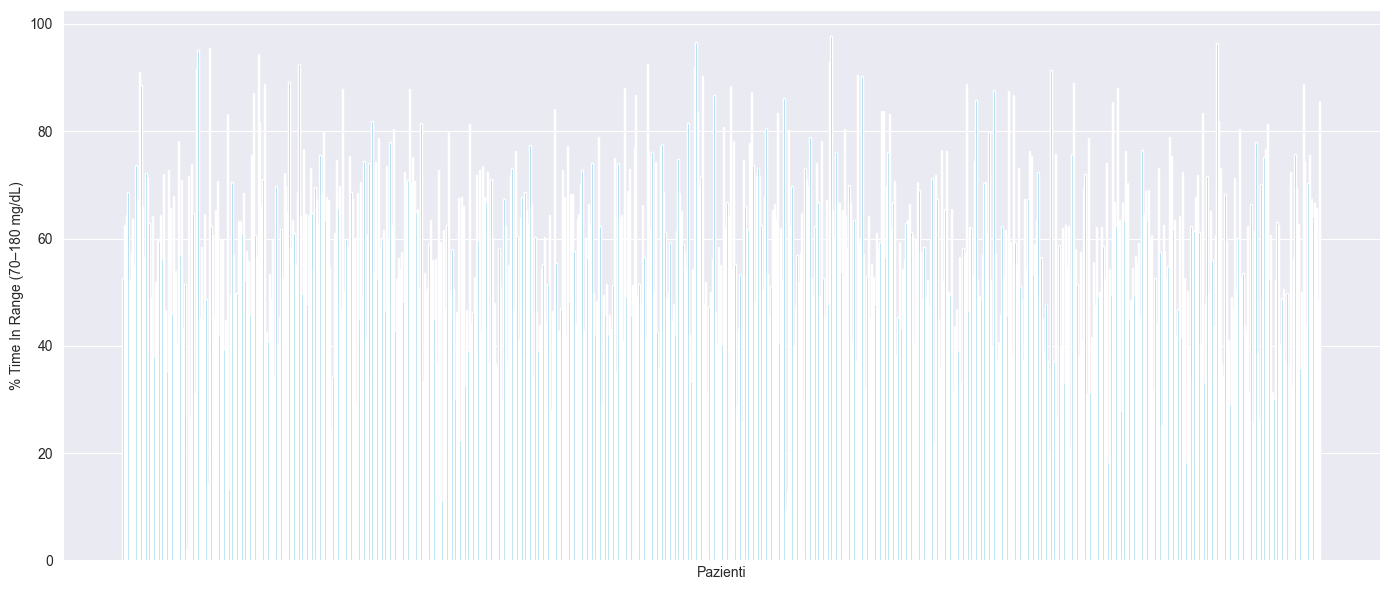

count    736.000000
mean      58.506127
std       15.705978
min        2.175836
25%       48.233346
50%       59.478182
75%       69.117657
max       97.715121
Name: %TIR, dtype: float64


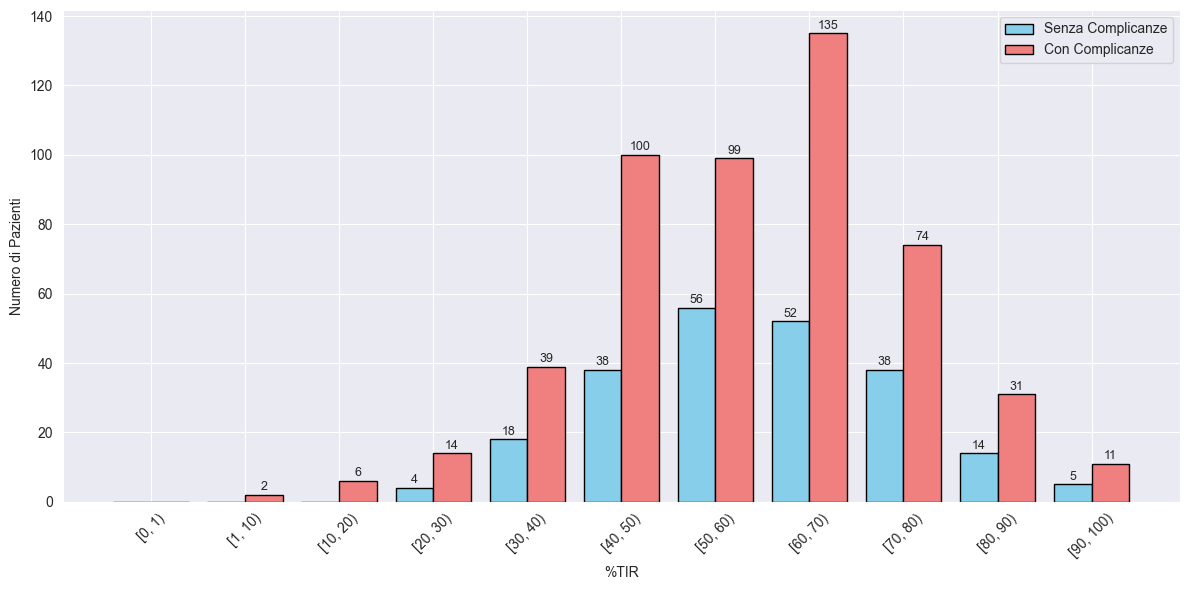

U-statistic = 59501.00
p-value      = 0.4487

Statistiche per il gruppo 'Senza Complicanze':
 - Media:   59.39
 - Mediana: 59.28
 - IQR:     20.63 (Q3: 70.16, Q1: 49.53)

Statistiche per il gruppo 'Con Complicanze':
 - Media:   58.12
 - Mediana: 59.50
 - IQR:     21.46 (Q3: 68.75, Q1: 47.29)
Media: 58.51
Mediana: 59.48
Asimmetria (skewness): -0.18
Curtosi (kurtosis): 0.07
Numero di outlier: 6
Moda: [62.0]
Q1:  48.23
Q3:  69.12
IQR: 20.88


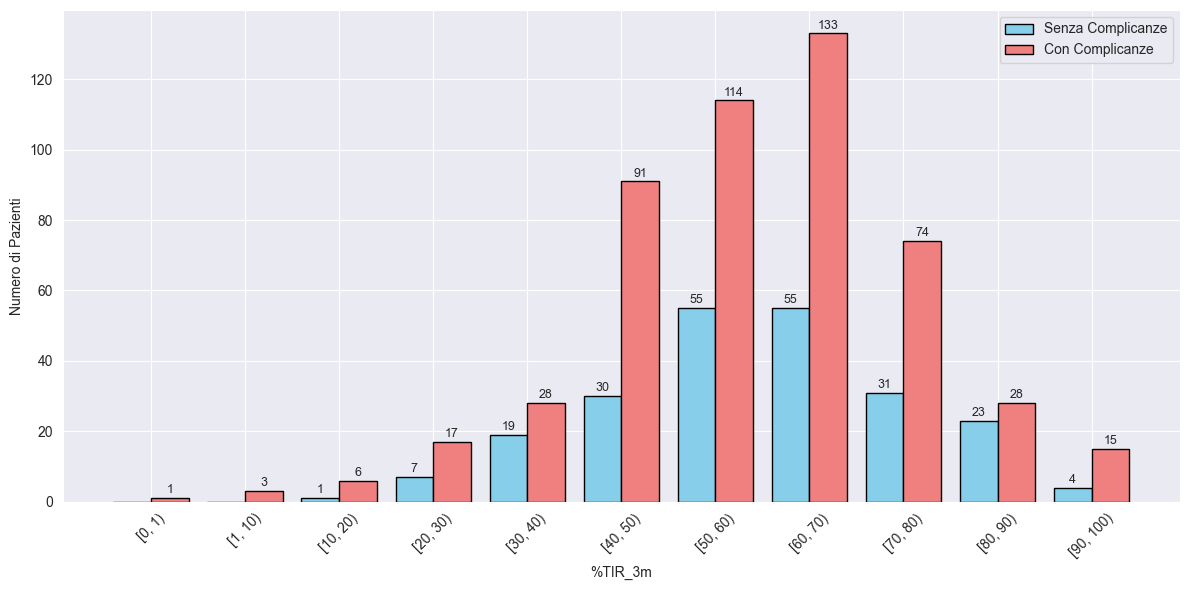

count    736.000000
mean      59.078697
std       16.275946
min        0.000000
25%       49.054784
50%       59.905338
75%       69.517486
max      100.000000
Name: %TIR_3m, dtype: float64


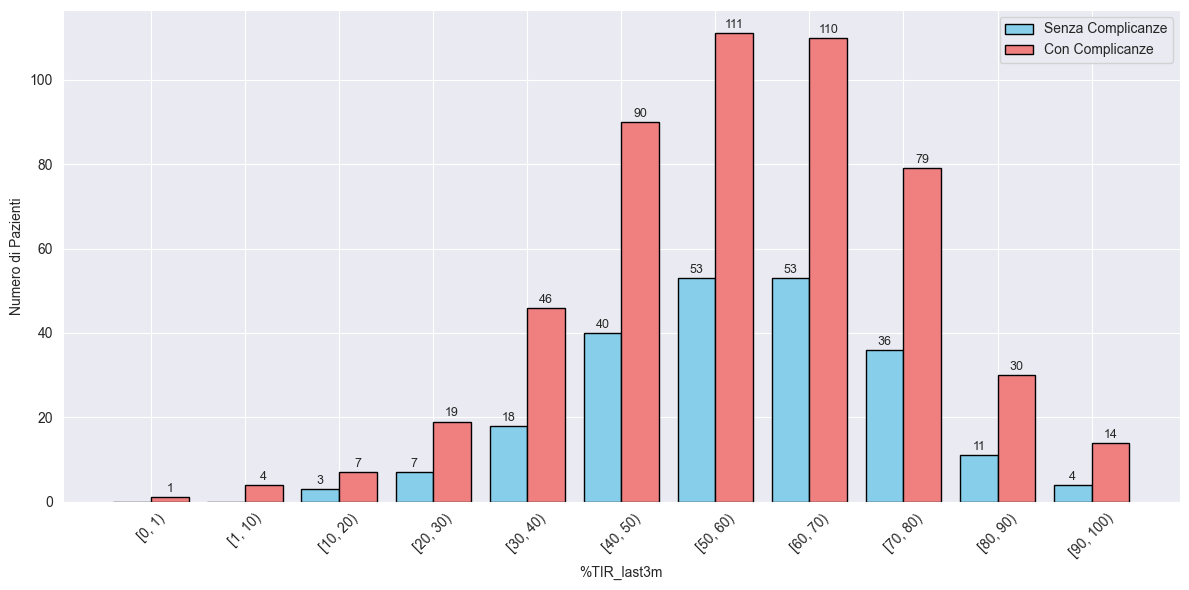

count    736.000000
mean      57.445243
std       16.941921
min        0.706215
25%       46.160972
50%       57.727208
75%       69.060569
max       97.514764
Name: %TIR_last3m, dtype: float64
Confronto TIR Primi 3 Mesi vs Ultimi 3 Mesi
 U-statistic = 285541.00
 p-value      = 0.0716
→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).


In [2]:
from scipy.stats import mannwhitneyu
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# ANALISI TIR
############################################################################################
# ------------------------------------------------------------------------------------------------
# 1) CARICAMENTO DEI DATI
# ------------------------------------------------------------------------------------------------
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")
# ------------------------------------------------------------------------------------------------
# 2) FUNZIONE PER CALCOLARE IL TIR DI UN PAZIENTE
#    Prende in ingresso il DataFrame delle misurazioni di un singolo paziente
# ------------------------------------------------------------------------------------------------
def calculate_tir(misurazioni):
    totale = len(misurazioni)  # numero totale di misurazioni
    righe_valide = misurazioni[
        (misurazioni['Measurement'] >= 70) &
        (misurazioni['Measurement'] <= 180)
    ]  # seleziona le misurazioni in range 70-180 mg/dL
    tir = len(righe_valide) / totale * 100  # percentuale Time In Range
    return tir

# ------------------------------------------------------------------------------------------------
# 3) CALCOLO TIR COMPLESSIVO PER OGNI PAZIENTE
#    Uso include_groups=False per evitare il DeprecationWarning
# ------------------------------------------------------------------------------------------------
pazienti = df.groupby('Patient_ID')
tir_by_paziente = pazienti.apply(
    calculate_tir,
    include_groups=False              # evita warning su grouping columns
).reset_index(name='%TIR')

# Fai il merge su Patient_ID per aggiungere la colonna %TIR
parte1 = parte1.merge(tir_by_paziente, on='Patient_ID', how='left')

# (Facoltativo) Controlla se ci sono pazienti senza misurazioni
missing = parte1['%TIR'].isna().sum()
if missing > 0:
    print(f"Attenzione: {missing} pazienti non hanno misurazioni glucose e avranno %TIR=NaN")

# Salva il risultato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TIR.")


# Stampa del DataFrame %TIR
print(tir_by_paziente)

# ------------------------------------------------------------------------------------------------
# 4) GRAFICO BAR PLOT PER %TIR DI OGNI PAZIENTE
# ------------------------------------------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.bar(tir_by_paziente['Patient_ID'], tir_by_paziente['%TIR'], color='skyblue')
plt.xticks([])  # nasconde le etichette X per chiarezza
plt.ylabel('% Time In Range (70–180 mg/dL)')
plt.xlabel('Pazienti')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TIR
print(tir_by_paziente['%TIR'].describe())

# ------------------------------------------------------------------------------------------------
# 5) RAGGRUPPAMENTO IN INTERVALLI E CONTEGGIO PAZIENTI
#    Uso observed=False per evitare il FutureWarning
# ------------------------------------------------------------------------------------------------
bins = [0, 1] + list(range(10, 110, 10))
tir_by_paziente['Interval'] = pd.cut(
    tir_by_paziente['%TIR'],
    bins=bins,
    right=False
)

# Flag per presenza di diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tir_by_paziente['Has_Diagnosis'] = tir_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Conteggio per ciascun intervallo e condizione
conta_per_interval = (
    tir_by_paziente
      .groupby(
          ['Interval', 'Has_Diagnosis'],
          observed=False              # evita warning su observed default
      )
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# ------------------------------------------------------------------------------------------------
# 6) ISTOGRAMMA A BARRE AFFIANCATE PER INTERVALLO
# ------------------------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = list(range(len(conta_per_interval)))

bar1 = plt.bar(
    [i - bar_width/2 for i in index],
    conta_per_interval[False],
    width=bar_width,
    label='Senza Complicanze',
    color='skyblue',
    edgecolor='black'
)
bar2 = plt.bar(
    [i + bar_width/2 for i in index],
    conta_per_interval[True],
    width=bar_width,
    label='Con Complicanze',
    color='lightcoral',
    edgecolor='black'
)

# Aggiunta etichette numeriche sopra le barre
for bars in (bar1, bar2):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.5,
                str(int(h)),
                ha='center', va='bottom', fontsize=9
            )

plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TIR')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------------------------
# 7) TEST STATISTICO MANN–WHITNEY U
# ------------------------------------------------------------------------------------------------
g0 = tir_by_paziente.loc[~tir_by_paziente['Has_Diagnosis'], '%TIR']
g1 = tir_by_paziente.loc[ tir_by_paziente['Has_Diagnosis'], '%TIR']
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')
print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")

# ------------------------------------------------------------------------------------------------
# 8) STATISTICHE AGGIUNTIVE: MEDIA, MEDIANA, ASIMMETRIA, CURTOSI, OUTLIER, MODA
# ------------------------------------------------------------------------------------------------
tir_values = tir_by_paziente['%TIR']
media    = tir_values.mean()
mediana  = tir_values.median()
asim     = skew(tir_values)
curto    = kurtosis(tir_values)
moda     = tir_values.round().mode()
q1, q3   = tir_values.quantile([0.25, 0.75])
iqr      = q3 - q1
outliers = tir_values[
    (tir_values < q1 - 1.5 * iqr) |
    (tir_values > q3 + 1.5 * iqr)
]

print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asim:.2f}")
print(f"Curtosi (kurtosis): {curto:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

q1_total, q3_total = tir_values.quantile([0.25, 0.75])
iqr_total = q3_total - q1_total
print(f"Q1:  {q1_total:.2f}")
print(f"Q3:  {q3_total:.2f}")
print(f"IQR: {iqr_total:.2f}")

# ------------------------------------------------------------------------------------------------
# 9) CALCOLO TIR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------
df['Measurement_date'] = pd.to_datetime(df['Measurement_date']) # trasforma la colonna Measurement_date del glucosio in oggetti datetime
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')    # per ogni paziente calcola la data della prima misurazione
df = df.join(first_dates, on='Patient_ID')  # aggiunge al dataset di partenza la colonna che indica la prima data di misurazione del glucosio

df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)] #crea un sotto-dataset che cotiene solo le righe in cui la data di misurazione é ≤ (prima data + 3 mesi)
pazienti_3m = df_3m.groupby('Patient_ID')   # ragruppa il risultato per paziente
tir3m_by_paziente = pazienti_3m.apply(      # sul dataset ottenuto che contiene solo i primi 3 mesi di misurazioni per paziente calcola il TIR e lo aggiunge come colonna
    calculate_tir,
    include_groups=False              # evita warning anche qui
).reset_index(name='%TIR_3m')

# Al dataset aggiunge anche il campo Has_Diagnosis che indica se il paziente ha o meno una complicanza
tir3m_by_paziente['Has_Diagnosis'] = tir3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)
tir3m_by_paziente['Interval'] = pd.cut(     # raggruppa i valori di TIR in intervalli da 10
    tir3m_by_paziente['%TIR_3m'],
    bins=bins,
    right=False
)


conta_per_interval_3m = (
    tir3m_by_paziente
      .groupby(
          ['Interval', 'Has_Diagnosis'],
          observed=False              # evita FutureWarning anche qui
      )
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Istogramma primi 3 mesi
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = list(range(len(conta_per_interval_3m)))

bar1_3m = plt.bar(
    [i - bar_width/2 for i in index_3m],
    conta_per_interval_3m[False],
    width=bar_width,
    label='Senza Complicanze', edgecolor='black', color='skyblue',
)
bar2_3m = plt.bar(
    [i + bar_width/2 for i in index_3m],
    conta_per_interval_3m[True],
    width=bar_width,
    label='Con Complicanze', edgecolor='black', color='lightcoral',
)
for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                     str(int(h)), ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TIR_3m')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# Statistiche descrittive %TIR_3m
print(tir3m_by_paziente['%TIR_3m'].describe())


# ------------------------------------------------------------------------------------------------
# 10) CALCOLO TIR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])  # datetime
# Calcolo per ogni paziente la data dell'ultima misurazione
last_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
# Aggiungo la colonna LastDate al dataset
df = df.join(last_dates, on='Patient_ID')

# Filtro alle righe in cui la data di misurazione è ≥ (ultima data - 3 mesi)
df_last3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]
# Raggruppo per paziente
pazienti_last3m = df_last3m.groupby('Patient_ID')

# Calcolo %TIR sugli ultimi 3 mesi per ciascun paziente
tir_last3m_by_paziente = pazienti_last3m.apply(
    calculate_tir,
    include_groups=False
).reset_index(name='%TIR_last3m')

# Aggiungo flag complicanze e fasce di %TIR
tir_last3m_by_paziente['Has_Diagnosis'] = tir_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)
tir_last3m_by_paziente['Interval'] = pd.cut(
    tir_last3m_by_paziente['%TIR_last3m'],
    bins=bins,
    right=False
)

# Conteggio per intervallo e condizione
conta_per_interval_last3m = (
    tir_last3m_by_paziente
      .groupby(['Interval', 'Has_Diagnosis'], observed=False)
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Istogramma ultimi 3 mesi
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_l3m = range(len(conta_per_interval_last3m))

bar1_l3m = plt.bar(
    [i - bar_width/2 for i in index_l3m],
    conta_per_interval_last3m[False],
    width=bar_width,
    label='Senza Complicanze', edgecolor='black', color='skyblue'
)
bar2_l3m = plt.bar(
    [i + bar_width/2 for i in index_l3m],
    conta_per_interval_last3m[True],
    width=bar_width,
    label='Con Complicanze', edgecolor='black', color='lightcoral'
)
for bars in (bar1_l3m, bar2_l3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.5,
                str(int(h)),
                ha='center', va='bottom', fontsize=9
            )

plt.xticks(index_l3m, [str(i) for i in conta_per_interval_last3m.index], rotation=45)
plt.xlabel('%TIR_last3m')
plt.ylabel('Numero di Pazienti')
plt.legend()
plt.tight_layout()
plt.show()

# Statistiche descrittive %TIR_last3m
print(tir_last3m_by_paziente['%TIR_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# 11) TEST STATISTICO MANN–WHITNEY U: confronto TIR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tir_first3m = tir3m_by_paziente['%TIR_3m']
tir_last3m  = tir_last3m_by_paziente['%TIR_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tir_first3m, tir_last3m, alternative='two-sided')

print("Confronto TIR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")


############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import mannwhitneyu

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TAR
############################################################################################
# Funzione per calcolare il TAR di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] > 180)] # Seleziona solo le righe che nel campo Measurement hanno un valore maggiore di 180 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TAR facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar,include_groups=False ).reset_index(name='%TAR') # Calcoliamo il TAR di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TAR
# tar_by_paziente = tar_by_paziente.sort_values(by='%TAR', ascending=False)
print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TAR'], color='skyblue')
plt.xticks([])
plt.ylabel('% Time Above Range (> 180 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TAR
print(tar_by_paziente['%TAR'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TAR'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'],observed=False  ).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TAR')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()



tar_values = tar_by_paziente['%TAR']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TAR considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# Estrai le due serie
g0 = tar_by_paziente.loc[ tar_by_paziente['Has_Diagnosis']==False, '%TAR']
g1 = tar_by_paziente.loc[ tar_by_paziente['Has_Diagnosis']==True,  '%TAR']

# Esegui il test two-sided
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')

print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")
############################################################################################

Aggiornato Excel/Parte1.csv con la colonna %TARLV1.
    Patient_ID    %TARLV1
0    LIB193263  32.187427
1    LIB193264  21.868817
2    LIB193265  13.305136
3    LIB193266  23.562595
4    LIB193267  29.505775
..         ...        ...
731  LIB194162  20.858254
732  LIB194163  20.405520
733  LIB194164  24.978578
734  LIB194165  29.262876
735  LIB194166  10.964281

[736 rows x 2 columns]


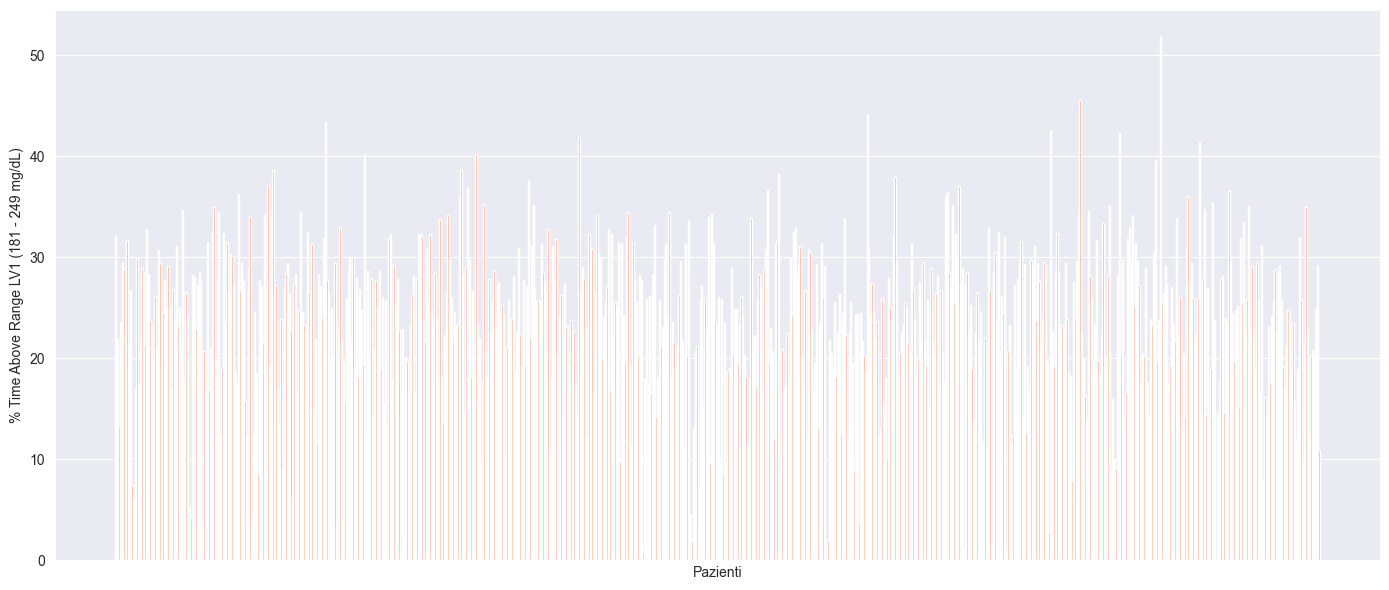

count    736.000000
mean      23.764796
std        7.534126
min        0.000000
25%       19.397705
50%       24.300905
75%       28.590132
max       51.869369
Name: %TARLV1, dtype: float64


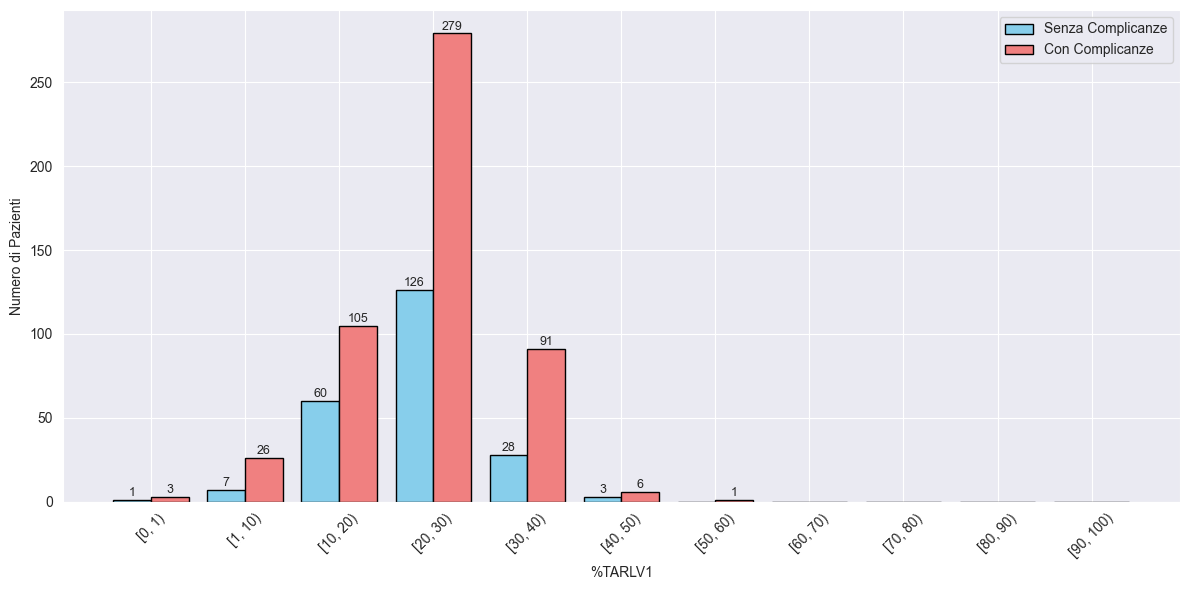

Q1 = 19.40%, Q3 = 28.59%, IQR = 9.19%
Soglia inferiore = 5.61%, soglia superiore = 42.38%
Valori TARLV1 considerati outlier:
[0.0, 0.0, 0.6885266147956033, 0.8106050427694926, 1.1597556709630548, 1.2704686617730097, 1.6025641025641024, 1.9639934533551555, 2.000230795861061, 2.3134608173978255, 2.765546543066821, 3.683265449130644, 3.7522268408551067, 3.7906779429071897, 4.1478612179796155, 4.272042621764725, 4.614590280317535, 5.279503105590062, 42.54737437541246, 43.402061855670105, 44.13838120104438, 45.51114255394411, 51.869369369369366]
Media: 23.76
Mediana: 24.30
Asimmetria (skewness): -0.41
Curtosi (kurtosis): 0.78
Numero di outlier: 23
Moda: [26.0]


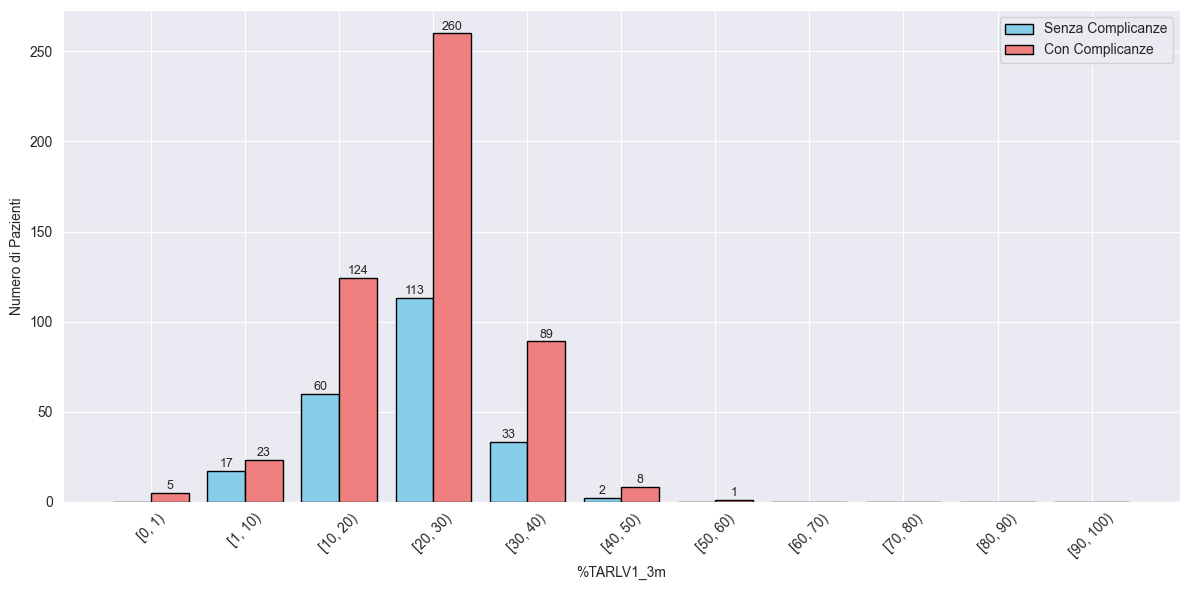

count    736.000000
mean      23.425696
std        8.488217
min        0.000000
25%       18.759577
50%       24.177579
75%       28.481424
max      100.000000
Name: %TARLV1_3m, dtype: float64


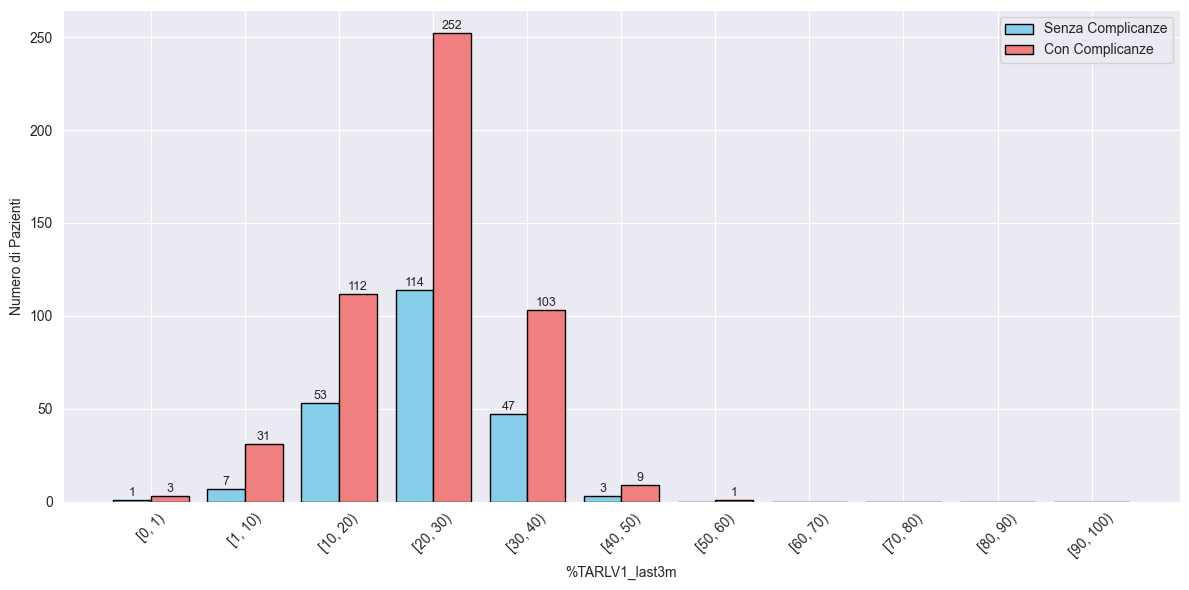

count    736.000000
mean      24.087956
std        8.056958
min        0.000000
25%       19.526608
50%       24.571310
75%       29.452771
max       56.580427
Name: %TARLV1_last3m, dtype: float64
Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi
 U-statistic = 255329.00
 p-value      = 0.0570
→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ANALISI TAR LV1
############################################################################################

parte1 = pd.read_csv("Excel/Parte1.csv")
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# Funzione per calcolare il TARLV1 di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 181) & (misurazioni['Measurement'] <= 249)] # Seleziona solo le righe che nel campo Measurement hanno un valore compreso tra 181 e 249 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TARLV1 facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV1') # Calcoliamo il TARLV1 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TARLV1
# tar_by_paziente = tar_by_paziente.sort_values(by='%TARLV1', ascending=False)

# Fai il merge su Patient_ID per aggiungere la colonna %TARLV1
parte1 = parte1.merge(tar_by_paziente, on='Patient_ID', how='left')

# Controlla se ci sono pazienti senza misurazioni
missing = parte1['%TARLV1'].isna().sum()
if missing > 0:
    print(f"Attenzione: {missing} pazienti non hanno misurazioni glucose e avranno %TARLV1=NaN")

# Salva il risultato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TARLV1.")

print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TARLV1'], color='#ffa07a')
plt.xticks([])
plt.ylabel('% Time Above Range LV1 (181 - 249 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TARLV1
print(tar_by_paziente['%TARLV1'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TARLV1'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()


# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TARLV1')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tar_values = tar_by_paziente['%TARLV1']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TARLV1 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV1_3m')

# 5) Aggiungo il flag di diagnosi
tar3m_by_paziente['Has_Diagnosis'] = tar3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar3m_by_paziente['Interval'] = pd.cut(tar3m_by_paziente['%TARLV1_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV1_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar3m_by_paziente['%TARLV1_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar_last3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV1_last3m')

# 5) Aggiungo il flag di diagnosi
tar_last3m_by_paziente['Has_Diagnosis'] = tar_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar_last3m_by_paziente['Interval'] = pd.cut(tar_last3m_by_paziente['%TARLV1_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV1_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar_last3m_by_paziente['%TARLV1_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TAR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tar_first3m = tar3m_by_paziente['%TARLV1_3m']
tar_last3m  = tar_last3m_by_paziente['%TARLV1_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tar_first3m, tar_last3m, alternative='two-sided')

print("Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")

############################################################################################

Aggiornato Excel/Parte1.csv con la colonna %TARLV2.
    Patient_ID    %TARLV2
0    LIB193263  13.303271
1    LIB193264   7.623101
2    LIB193265   6.567760
3    LIB193266   6.127504
4    LIB193267  16.696996
..         ...        ...
731  LIB194162   7.293660
732  LIB194163   8.031540
733  LIB194164   4.949443
734  LIB194165  17.688472
735  LIB194166   1.021815

[736 rows x 2 columns]


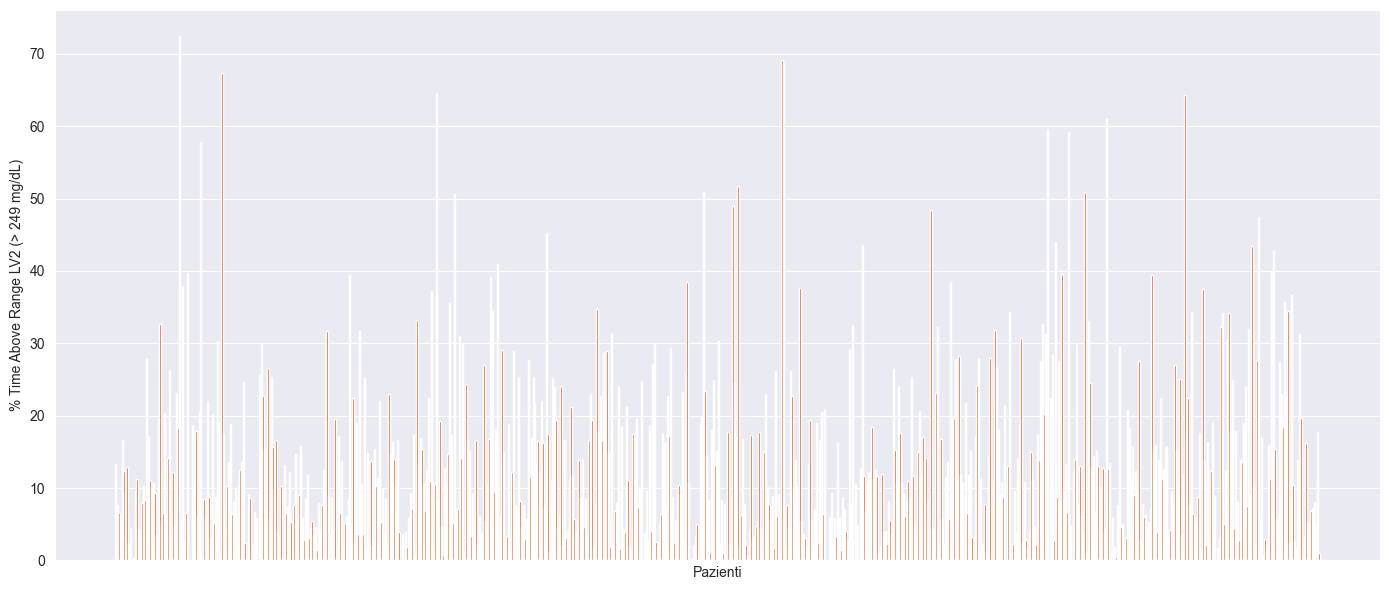

count    736.000000
mean      13.309700
std       11.938113
min        0.000000
25%        4.645998
50%       10.246298
75%       17.923225
max       72.439413
Name: %TARLV2, dtype: float64


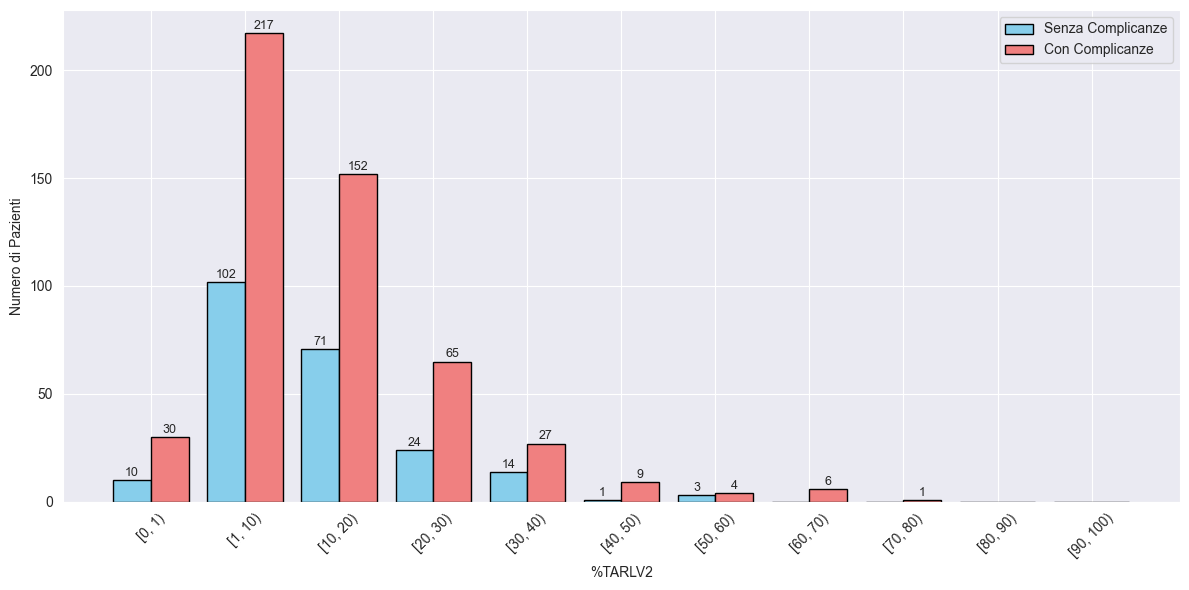

Q1 = 4.65%, Q3 = 17.92%, IQR = 13.28%
Soglia inferiore = -15.27%, soglia superiore = 37.84%
Valori TARLV2 considerati outlier:
[37.87262183335029, 38.42431645212816, 38.51095197978096, 39.14450035945363, 39.4694315522747, 39.50806003335186, 39.55368605064052, 39.67611336032389, 40.05708848715509, 40.9841372612496, 42.73729894185813, 43.50363827386279, 43.53741496598639, 43.945810864132575, 45.24793388429752, 47.48743718592965, 48.38344344074423, 48.97184435305283, 50.633035626656195, 50.84470435347629, 50.87281795511222, 51.796875, 57.77010360138135, 59.14285714285714, 59.66481595722804, 60.986301369863014, 64.34102544313241, 64.57598764637756, 67.36045411542099, 68.76474239602732, 69.13619167717529, 72.43941270122059]
Media: 13.31
Mediana: 10.25
Asimmetria (skewness): 1.73
Curtosi (kurtosis): 3.99
Numero di outlier: 32
Moda: [2.0]


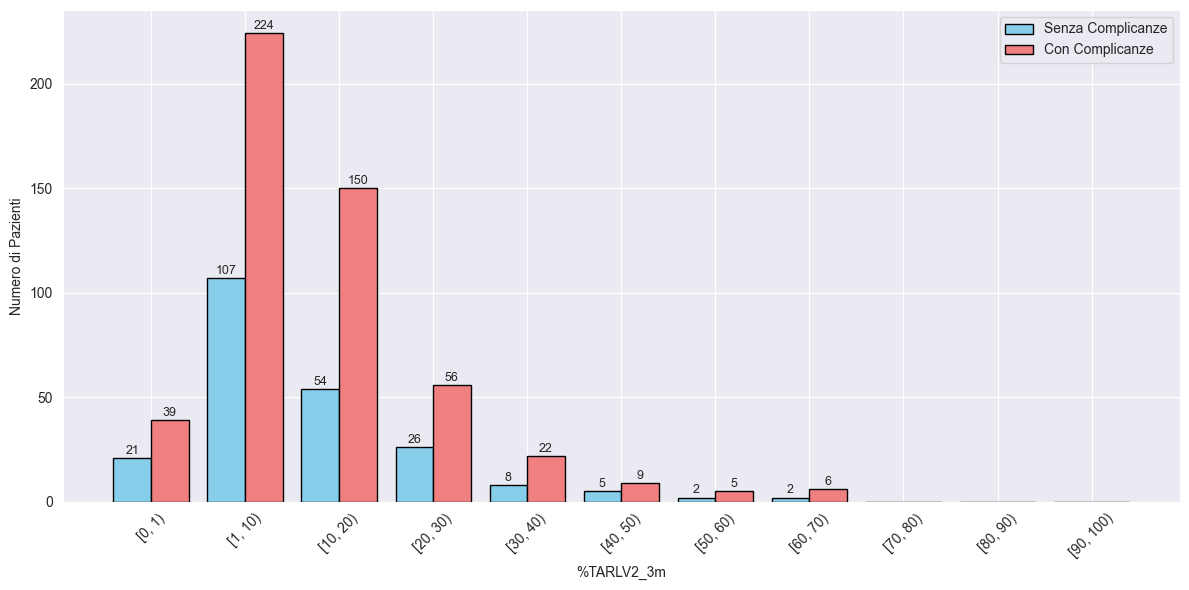

count    736.000000
mean      12.583098
std       12.091392
min        0.000000
25%        4.230082
50%        9.339258
75%       17.132323
max       69.136192
Name: %TARLV2_3m, dtype: float64


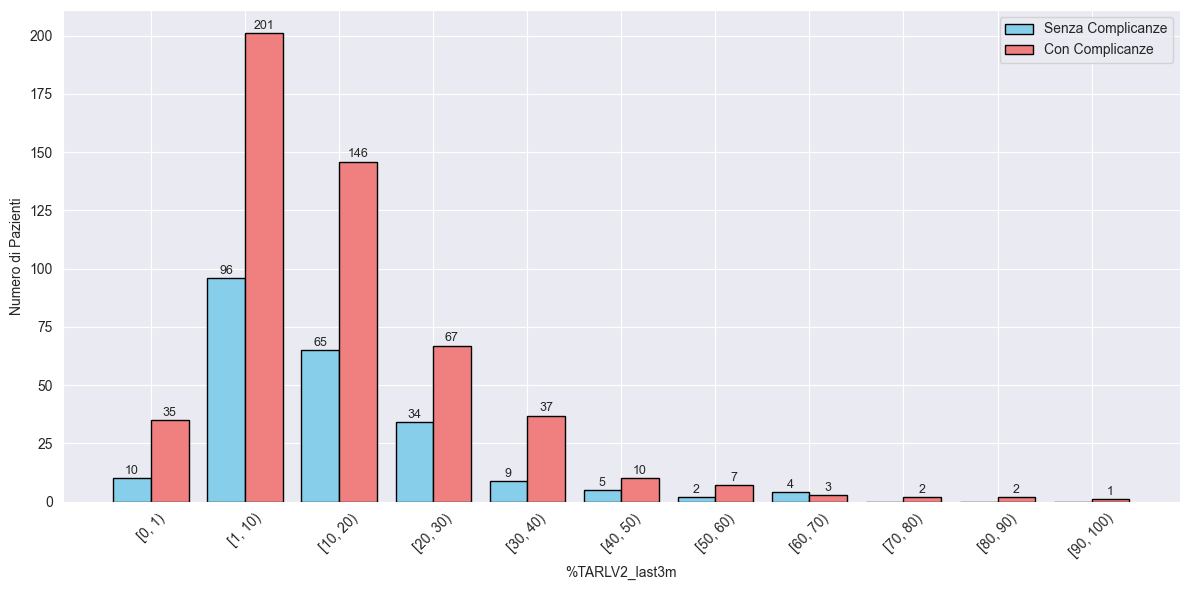

count    736.000000
mean      14.502538
std       13.619544
min        0.000000
25%        4.667122
50%       11.195356
75%       19.819495
max       92.069632
Name: %TARLV2_last3m, dtype: float64
Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi
 U-statistic = 247791.00
 p-value      = 0.0047
→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")

# ANALISI TAR LV2
############################################################################################
# Funzione per calcolare il TARLV2 di un paziente
def calculate_tar(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 250)] # Seleziona solo le righe che nel campo Measurement hanno un valore maggiore di 250 mg/dL
    tar = len(righe_valide)/totale * 100 # Calcola il %TARLV2 facendo Misurazioni Valide/Misurazioni Totali
    return tar

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tar_by_paziente = pazienti.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV2') # Calcoliamo il TARLV2 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TARLV2
# tar_by_paziente = tar_by_paziente.sort_values(by='%TARLV2', ascending=False)

# Fai il merge su Patient_ID per aggiungere la colonna %TARLV2
parte1 = parte1.merge(tar_by_paziente, on='Patient_ID', how='left')

# Controlla se ci sono pazienti senza misurazioni
missing = parte1['%TARLV2'].isna().sum()
if missing > 0:
    print(f"Attenzione: {missing} pazienti non hanno misurazioni glucose e avranno %TARLV2=NaN")

# Salva il risultato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TARLV2.")

print(tar_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tar_by_paziente['Patient_ID'], tar_by_paziente['%TARLV2'], color='#e64100')
plt.xticks([])
plt.ylabel('% Time Above Range LV2 (> 249 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TARLV2
print(tar_by_paziente['%TARLV2'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tar_intervals = pd.cut(tar_by_paziente['%TARLV2'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tar_by_paziente['Has_Diagnosis'] = tar_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tar_by_paziente['Interval'] = tar_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tar_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TARLV2')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tar_values = tar_by_paziente['%TARLV2']

# Statistiche descrittive
media = tar_values.mean()
mediana = tar_values.median()
asimmetria = skew(tar_values) #skewness
curtosi = kurtosis(tar_values)

tar_arrotondato = tar_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tar_values.quantile(0.25)
q3 = tar_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tar_values[(tar_values < lower_thr) | (tar_values > upper_thr)]
print("Valori TARLV2 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------


# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False).reset_index(name='%TARLV2_3m')

# 5) Aggiungo il flag di diagnosi
tar3m_by_paziente['Has_Diagnosis'] = tar3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar3m_by_paziente['Interval'] = pd.cut(tar3m_by_paziente['%TARLV2_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV2_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar3m_by_paziente['%TARLV2_3m'].describe())


# ------------------------------------------------------------------------------------------------
# CALCOLO TAR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tar_last3m_by_paziente = pazienti_3m.apply(calculate_tar, include_groups=False ).reset_index(name='%TARLV2_last3m')

# 5) Aggiungo il flag di diagnosi
tar_last3m_by_paziente['Has_Diagnosis'] = tar_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tar_last3m_by_paziente['Interval'] = pd.cut(tar_last3m_by_paziente['%TARLV2_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tar_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TARLV2_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tar_last3m_by_paziente['%TARLV2_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TAR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tar_first3m = tar3m_by_paziente['%TARLV2_3m']
tar_last3m  = tar_last3m_by_paziente['%TARLV2_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tar_first3m, tar_last3m, alternative='two-sided')

print("Confronto TAR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import mannwhitneyu

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TBR
############################################################################################
# Funzione per calcolare il TBR di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] < 70)] # Seleziona solo le righe che nel campo Measurement hanno un valore minore di 70 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBR facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False).reset_index(name='%TBR') # Calcoliamo il TBR di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBR
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBR', ascending=False)
print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBR'], color='skyblue')
plt.xticks([])
plt.ylabel('% Time Below Range (< 70 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBR
print(tbr_by_paziente['%TBR'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBR'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()


# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBR')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()



tbr_values = tbr_by_paziente['%TBR']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBR considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())

# Estrai le due serie
g0 = tbr_by_paziente.loc[ tbr_by_paziente['Has_Diagnosis']==False, '%TBR']
g1 = tbr_by_paziente.loc[ tbr_by_paziente['Has_Diagnosis']==True,  '%TBR']

# Esegui il test two-sided
u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')

# STATISTICHE PER GRUPPO
for nome_gruppo, gruppo in zip(["Senza Complicanze", "Con Complicanze"], [g0, g1]):
    media   = gruppo.mean()
    mediana = gruppo.median()
    q1      = gruppo.quantile(0.25)
    q3      = gruppo.quantile(0.75)
    iqr     = q3 - q1

    print(f"\nStatistiche per il gruppo '{nome_gruppo}':")
    print(f" - Media:   {media:.2f}")
    print(f" - Mediana: {mediana:.2f}")
    print(f" - IQR:     {iqr:.2f} (Q3: {q3:.2f}, Q1: {q1:.2f})")

print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")
############################################################################################

Aggiornato Excel/Parte1.csv con la colonna %TBRLV1.
    Patient_ID    %TBRLV1
0    LIB193263   1.520849
1    LIB193264   6.790607
2    LIB193265  12.109241
3    LIB193266   1.554929
4    LIB193267   1.466640
..         ...        ...
731  LIB194162   6.252990
732  LIB194163   4.522670
733  LIB194164   4.121680
734  LIB194165   4.010393
735  LIB194166   2.187463

[736 rows x 2 columns]


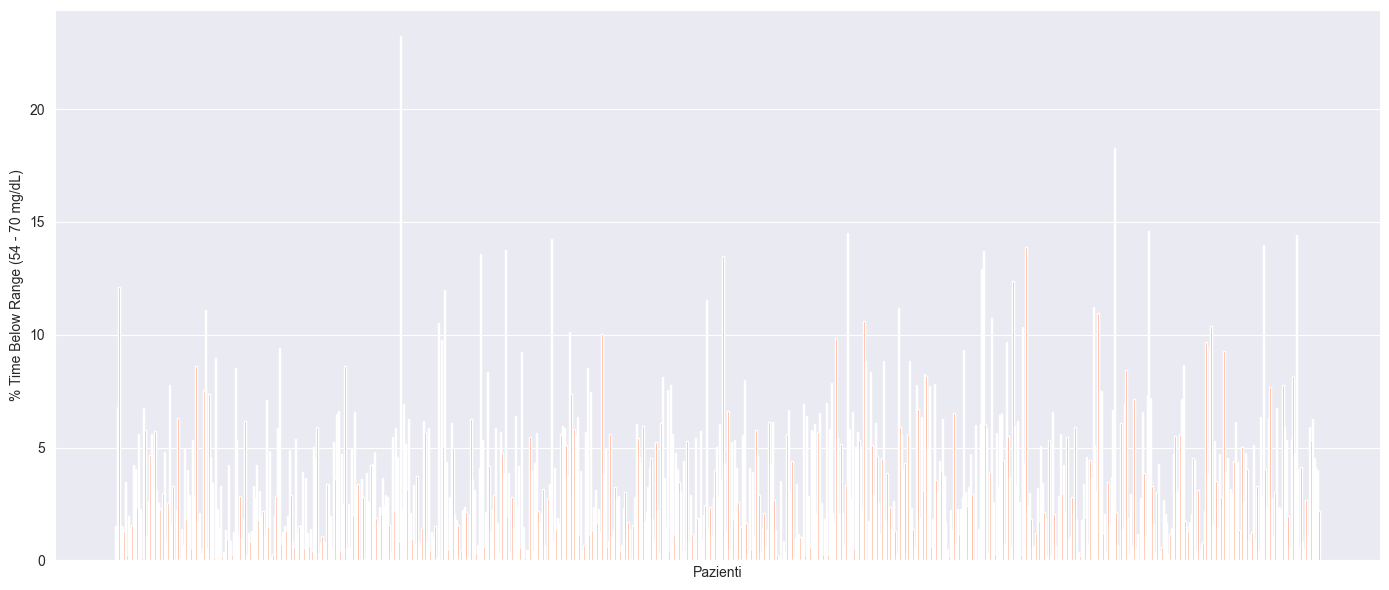

count    736.000000
mean       3.530091
std        2.984482
min        0.000000
25%        1.300223
50%        2.822725
75%        5.269218
max       23.224713
Name: %TBRLV1, dtype: float64


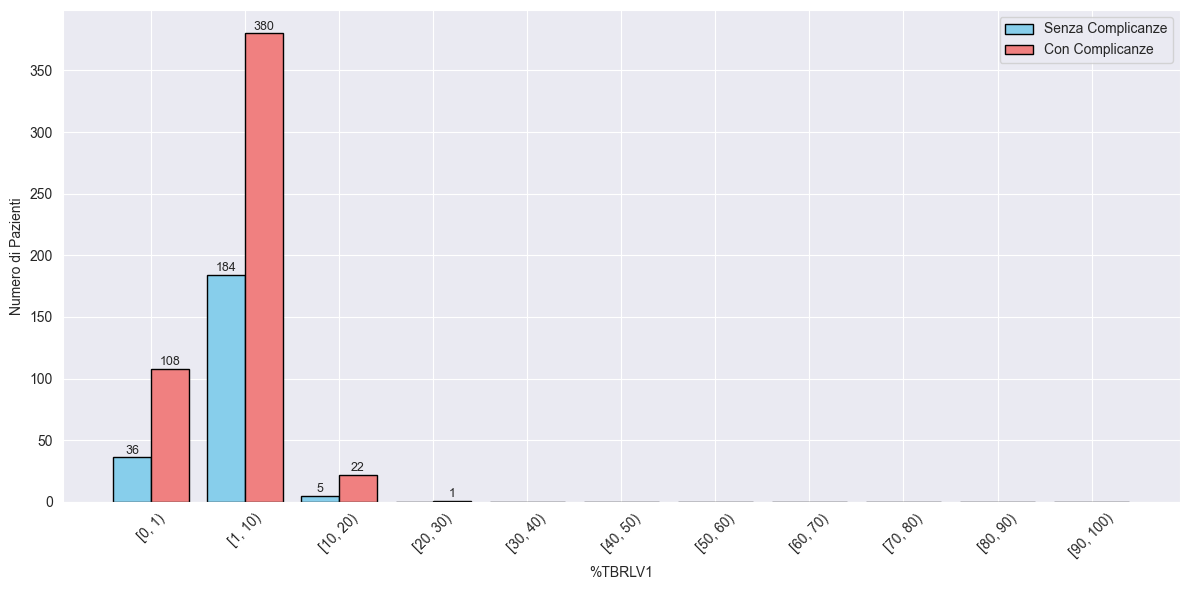

Q1 = 1.30%, Q3 = 5.27%, IQR = 3.97%
Soglia inferiore = -4.65%, soglia superiore = 11.22%
Valori TBRLV1 considerati outlier:
[11.234979006804691, 11.531755915317559, 11.997447351627313, 12.109240810717967, 12.367149758454106, 12.91466024612092, 13.490443496010391, 13.55568018762792, 13.700807159884572, 13.761763757366092, 13.903316020775069, 13.961799626732319, 14.222865412445731, 14.416522347912597, 14.513589658601258, 14.59965187119234, 18.262235649546827, 23.224712751930685]
Media: 3.53
Mediana: 2.82
Asimmetria (skewness): 1.60
Curtosi (kurtosis): 4.29
Numero di outlier: 18
Moda: [1.0]


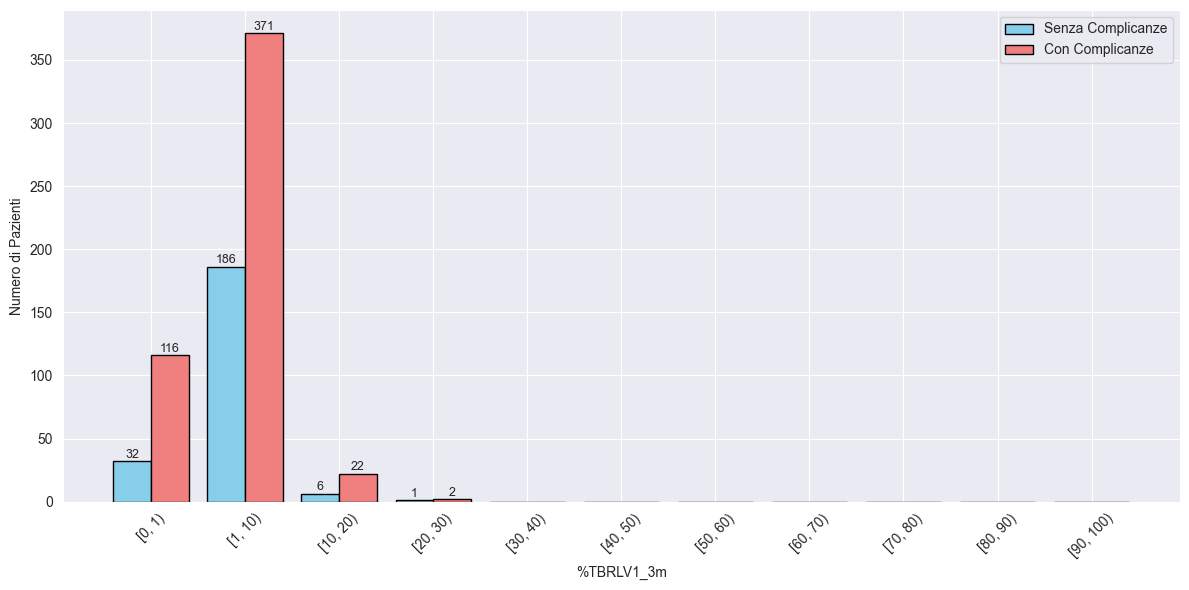

count    736.000000
mean       3.735095
std        3.186964
min        0.000000
25%        1.276710
50%        3.001930
75%        5.566171
max       24.649791
Name: %TBRLV1_3m, dtype: float64


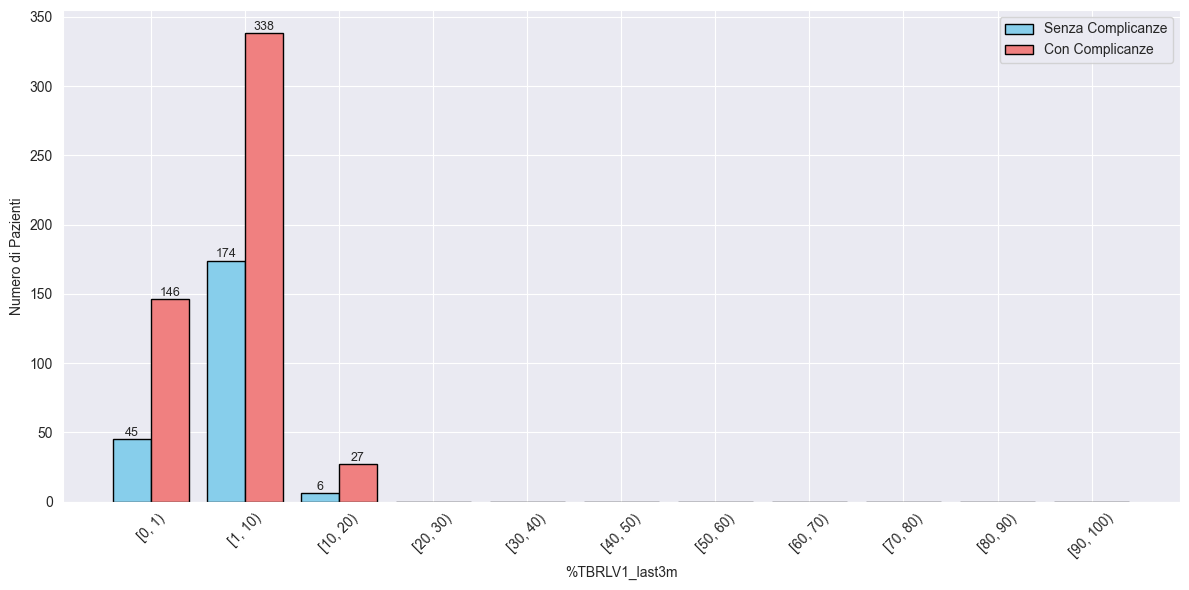

count    736.000000
mean       3.266788
std        3.076013
min        0.000000
25%        0.907440
50%        2.451768
75%        4.763425
max       19.865006
Name: %TBRLV1_last3m, dtype: float64
Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi
 U-statistic = 299531.50
 p-value      = 0.0004
→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

parte1 = pd.read_csv("Excel/Parte1.csv")
df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# ANALISI TBR LV1
############################################################################################
# Funzione per calcolare il TBRLV1 di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] >= 54) & (misurazioni['Measurement'] < 70)] # Seleziona solo le righe che nel campo Measurement hanno un valore compreso tra 54 e 70 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBRLV1 facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False ).reset_index(name='%TBRLV1') # Calcoliamo il TBRLV1 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBRLV1
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBRLV1', ascending=False)

# Fai il merge su Patient_ID per aggiungere la colonna %TARLV2
parte1 = parte1.merge(tbr_by_paziente, on='Patient_ID', how='left')

# Controlla se ci sono pazienti senza misurazioni
missing = parte1['%TBRLV1'].isna().sum()
if missing > 0:
    print(f"Attenzione: {missing} pazienti non hanno misurazioni glucose e avranno %TBRLV1=NaN")

# Salva il risultato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TBRLV1.")

print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBRLV1'], color='#ffa07a')
plt.xticks([])
plt.ylabel('% Time Below Range (54 - 70 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBRLV1
print(tbr_by_paziente['%TBRLV1'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBRLV1'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBRLV1')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tbr_values = tbr_by_paziente['%TBRLV1']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBRLV1 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())


# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV1_3m')

# 5) Aggiungo il flag di diagnosi
tbr3m_by_paziente['Has_Diagnosis'] = tbr3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr3m_by_paziente['Interval'] = pd.cut(tbr3m_by_paziente['%TBRLV1_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV1_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr3m_by_paziente['%TBRLV1_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr_last3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV1_last3m')

# 5) Aggiungo il flag di diagnosi
tbr_last3m_by_paziente['Has_Diagnosis'] = tbr_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr_last3m_by_paziente['Interval'] = pd.cut(tbr_last3m_by_paziente['%TBRLV1_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV1_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr_last3m_by_paziente['%TBRLV1_last3m'].describe())


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TBR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tbr_first3m = tbr3m_by_paziente['%TBRLV1_3m']
tbr_last3m  = tbr_last3m_by_paziente['%TBRLV1_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tbr_first3m, tbr_last3m, alternative='two-sided')

print("Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.4f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")
############################################################################################

Aggiornato Excel/Parte1.csv con la colonna %TBRLV2.
    Patient_ID   %TBRLV2
0    LIB193263  0.420979
1    LIB193264  1.243140
2    LIB193265  3.555479
3    LIB193266  0.148261
4    LIB193267  0.126124
..         ...       ...
731  LIB194162  1.303828
732  LIB194163  0.377358
733  LIB194164  0.269066
734  LIB194165  0.490299
735  LIB194166  0.188781

[736 rows x 2 columns]


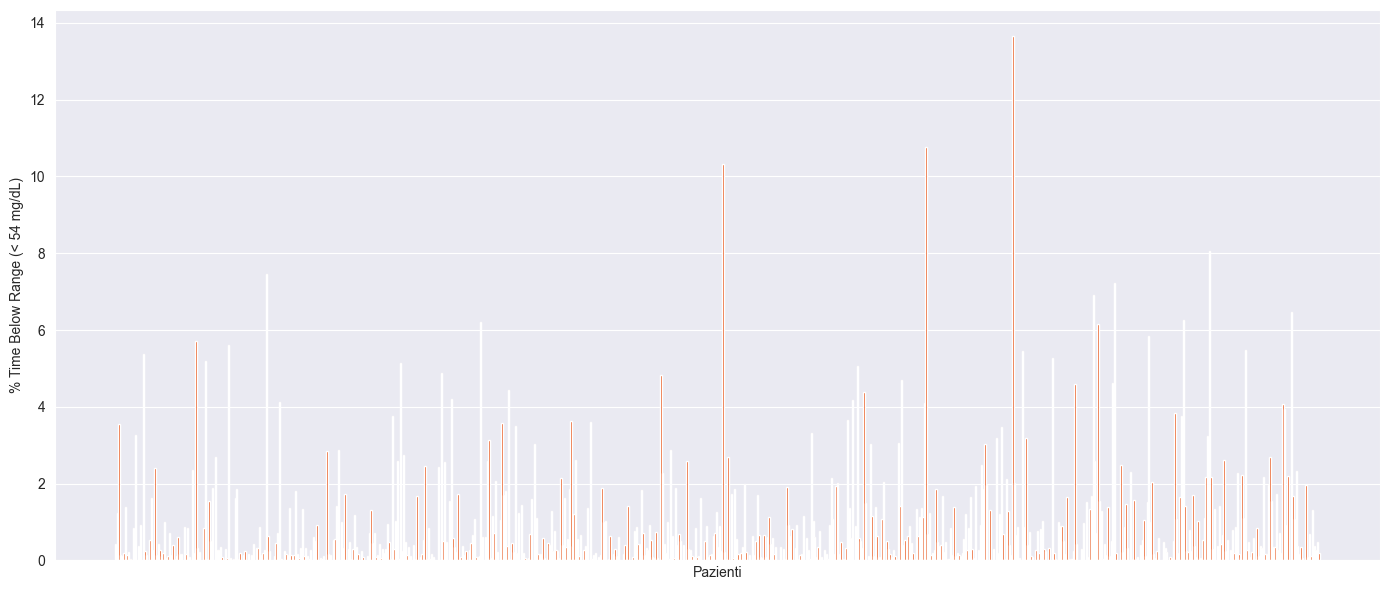

count    736.000000
mean       0.889286
std        1.429142
min        0.000000
25%        0.099240
50%        0.337024
75%        1.058319
max       13.652174
Name: %TBRLV2, dtype: float64


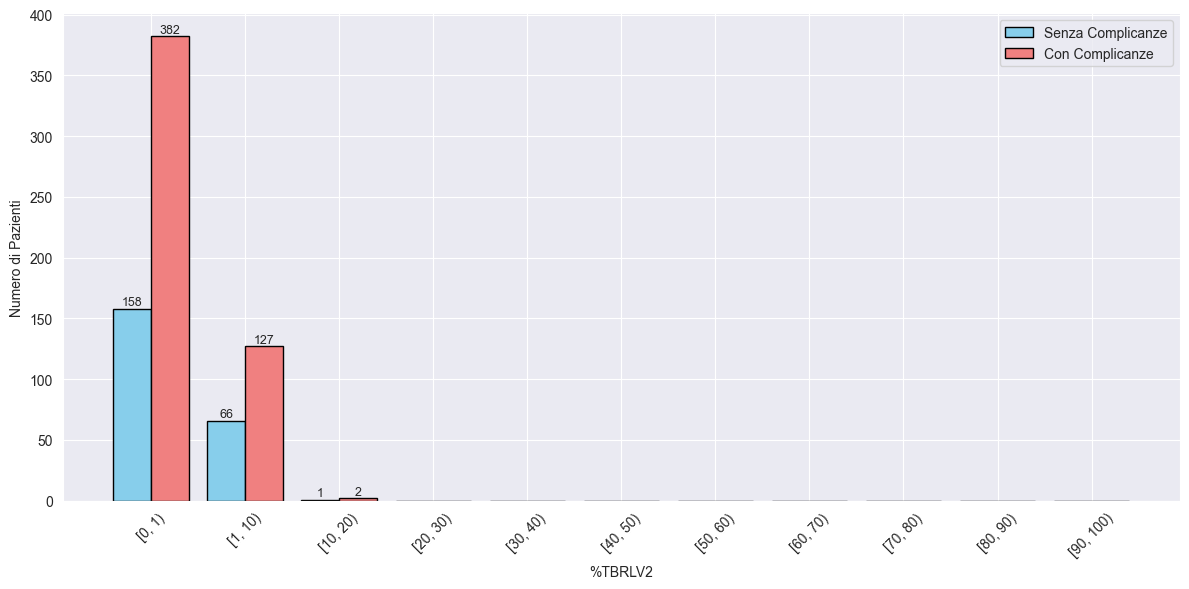

Q1 = 0.10%, Q3 = 1.06%, IQR = 0.96%
Soglia inferiore = -1.34%, soglia superiore = 2.50%
Valori TBRLV2 considerati outlier:
[2.5526483726866624, 2.5771183131589224, 2.589671401861125, 2.597584948048301, 2.6018808777429467, 2.6037029076729405, 2.6134425110883654, 2.6891081447088414, 2.7027027027027026, 2.7042381547551413, 2.7559055118110236, 2.8508077288565095, 2.8660017061486975, 2.8859660324351935, 3.0264817150063053, 3.0268869222507258, 3.040150044708089, 3.0543230086589412, 3.12540248143219, 3.1866162119099783, 3.1961646024770274, 3.232049545190633, 3.2661175802328883, 3.3271719038817005, 3.473639455782313, 3.504825054762892, 3.555479216763999, 3.5793161221536822, 3.606643817558661, 3.6198401401511004, 3.650149154789526, 3.7582069277790358, 3.7672100684179406, 3.833380183444212, 3.951686571708901, 4.069050554870531, 4.100838304046429, 4.136307588835332, 4.173627131227958, 4.195817418598495, 4.392471321973494, 4.432652409830833, 4.6080000000000005, 4.626559292594347, 4.698917768939044

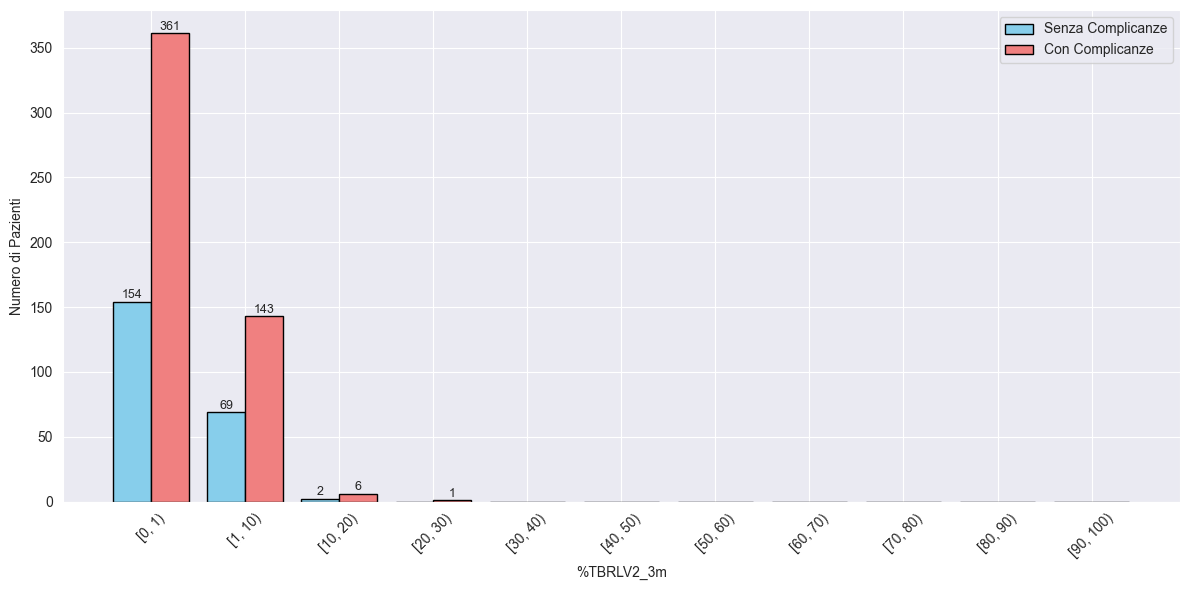

count    736.000000
mean       1.177414
std        2.162856
min        0.000000
25%        0.080005
50%        0.358561
75%        1.313960
max       25.065274
Name: %TBRLV2_3m, dtype: float64


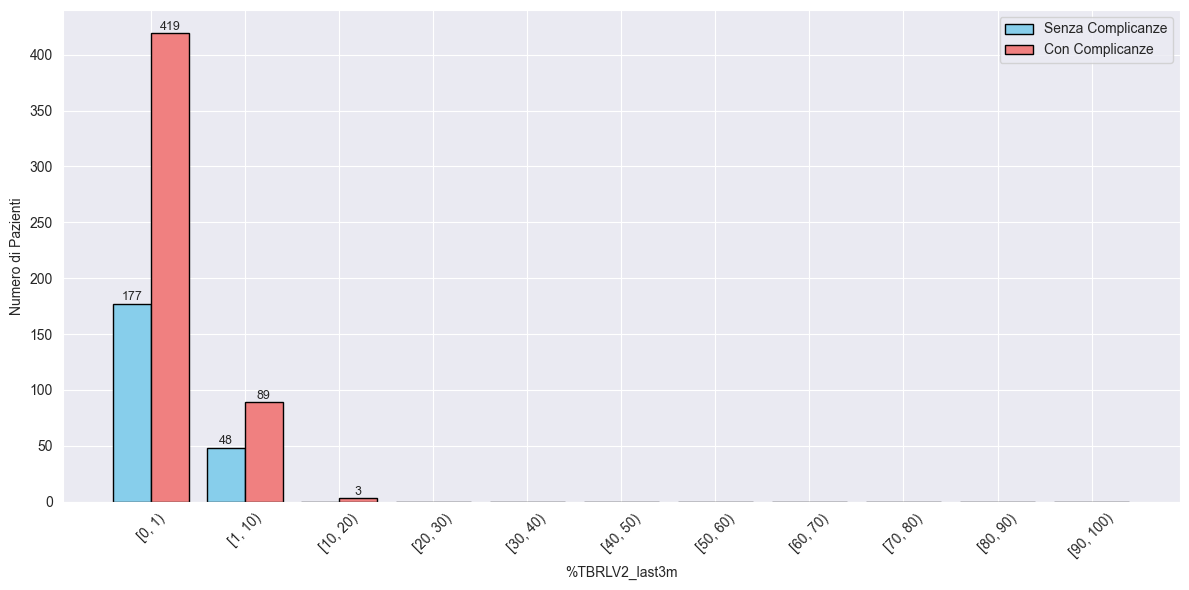

count    736.000000
mean       0.697476
std        1.345893
min        0.000000
25%        0.025985
50%        0.214082
75%        0.689269
max       11.890328
Name: %TBRLV2_last3m, dtype: float64
Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi
 U-statistic = 318159.00
 p-value      = 0.0000000062
→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

df = pd.read_csv("Excel/Glucose_measurements.csv")
diagnostics = pd.read_csv("Excel/Diagnostics.csv")
parte1 = pd.read_csv("Excel/Parte1.csv")

# ANALISI TBR LV2
############################################################################################
# Funzione per calcolare il TBRLV2 di un paziente
def calculate_tbr(misurazioni): # Prende in ingresso l'insieme di misurazioni di un singolo paziente
    totale = len(misurazioni)   # Calcola il numero totale di misurazioni del paziente
    righe_valide = misurazioni[(misurazioni['Measurement'] < 54)] # Seleziona solo le righe che nel campo Measurement hanno un valore minore di 54 mg/dL
    tbr = len(righe_valide)/totale * 100 # Calcola il %TBRLV2 facendo Misurazioni Valide/Misurazioni Totali
    return tbr

pazienti = df.groupby('Patient_ID') # Dividiamo il dataset per paziente, ogni gruppo contiene le misurazioni di un singolo paziente
tbr_by_paziente = pazienti.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2') # Calcoliamo il TBRLV2 di ogni paziente e creiamo un nuovo dataset con 2 colonne: Ptient_ID e %TBRLV2
# tbr_by_paziente = tbr_by_paziente.sort_values(by='%TBRLV2', ascending=False)

# Fai il merge su Patient_ID per aggiungere la colonna %TARLV2
parte1 = parte1.merge(tbr_by_paziente, on='Patient_ID', how='left')

# Controlla se ci sono pazienti senza misurazioni
missing = parte1['%TBRLV2'].isna().sum()
if missing > 0:
    print(f"Attenzione: {missing} pazienti non hanno misurazioni glucose e avranno %TBRLV2=NaN")

# Salva il risultato
parte1.to_csv("Excel/Parte1.csv", index=False)
print("Aggiornato Excel/Parte1.csv con la colonna %TBRLV2.")

print(tbr_by_paziente)

# Grafico per la percentuale di ogni paziente
plt.figure(figsize=(14, 6))
plt.bar(tbr_by_paziente['Patient_ID'], tbr_by_paziente['%TBRLV2'], color='#e64100')
plt.xticks([])
plt.ylabel('% Time Below Range (< 54 mg/dL)')
plt.xlabel('Pazienti')
plt.title('')
plt.tight_layout()
plt.show()

# Statistiche descrittive di %TBRLV2
print(tbr_by_paziente['%TBRLV2'].describe())

bins = [0, 1] + list(range(10, 110, 10))
tbr_intervals = pd.cut(tbr_by_paziente['%TBRLV2'], bins=bins, right=False)
#Notazione [0,10) 0 é incluso ma 10 no

# Aggiungiamo colonna per sapere se il paziente ha almeno una diagnosi
pazienti_con_diagnosi = set(diagnostics['Patient_ID'])
tbr_by_paziente['Has_Diagnosis'] = tbr_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# Aggiungiamo anche gli intervalli nel dataframe
tbr_by_paziente['Interval'] = tbr_intervals

# Calcoliamo il numero di pazienti CON e SENZA diagnosi per ogni intervallo
conta_per_interval = tbr_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0)
conta_per_interval = conta_per_interval.sort_index()

# Istogramma con due barre affiancate per ogni intervallo, con etichette
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(conta_per_interval))

bar1 = plt.bar([i - bar_width/2 for i in index], conta_per_interval[False], width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2 = plt.bar([i + bar_width/2 for i in index], conta_per_interval[True], width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

# Aggiunta delle etichette numeriche sopra ogni barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)


plt.xticks(index, [str(i) for i in conta_per_interval.index], rotation=45)
plt.xlabel('%TBRLV2')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()


tbr_values = tbr_by_paziente['%TBRLV2']

# Statistiche descrittive
media = tbr_values.mean()
mediana = tbr_values.median()
asimmetria = skew(tbr_values) #skewness
curtosi = kurtosis(tbr_values)

tar_arrotondato = tbr_values.round()
moda = tar_arrotondato.mode()

# Outlier con metodo IQR (Interquartile Range)
# calcola Q1, Q3 e IQR
q1 = tbr_values.quantile(0.25)
q3 = tbr_values.quantile(0.75)
iqr = q3 - q1

# soglie per outlier
lower_thr = q1 - 1.5 * iqr
upper_thr = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}%, Q3 = {q3:.2f}%, IQR = {iqr:.2f}%")
print(f"Soglia inferiore = {lower_thr:.2f}%, soglia superiore = {upper_thr:.2f}%")
outliers = tbr_values[(tbr_values < lower_thr) | (tbr_values > upper_thr)]
print("Valori TBRLV2 considerati outlier:")
print(outliers.sort_values().to_list())



# Output
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Asimmetria (skewness): {asimmetria:.2f}")
print(f"Curtosi (kurtosis): {curtosi:.2f}")
print(f"Numero di outlier: {len(outliers)}")
print("Moda:", moda.tolist())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUI PRIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo la prima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].min().rename('FirstDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data iniziale
df_3m = df[df['Measurement_date'] <= df['FirstDate'] + pd.DateOffset(months=3)]

# 4) Calcolo il TIR sui primi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2_3m')

# 5) Aggiungo il flag di diagnosi
tbr3m_by_paziente['Has_Diagnosis'] = tbr3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr3m_by_paziente['Interval'] = pd.cut(tbr3m_by_paziente['%TBRLV2_3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV2_3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr3m_by_paziente['%TBRLV2_3m'].describe())



# ------------------------------------------------------------------------------------------------
# CALCOLO TBR SUGLI ULTIMI 3 MESI
# ------------------------------------------------------------------------------------------------

# 1) Converto Measurement_date in datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

# 2) Calcolo l'ultima data di misurazione per ogni paziente
first_dates = df.groupby('Patient_ID')['Measurement_date'].max().rename('LastDate')
df = df.join(first_dates, on='Patient_ID')

# 3) Seleziono misurazioni entro 3 mesi dalla data finale
df_3m = df[df['Measurement_date'] >= df['LastDate'] - pd.DateOffset(months=3)]

# 4) Calcolo il TIR sugli ultimi 3 mesi
pazienti_3m = df_3m.groupby('Patient_ID')
tbr_last3m_by_paziente = pazienti_3m.apply(calculate_tbr, include_groups=False).reset_index(name='%TBRLV2_last3m')

# 5) Aggiungo il flag di diagnosi
tbr_last3m_by_paziente['Has_Diagnosis'] = tbr_last3m_by_paziente['Patient_ID'].isin(pazienti_con_diagnosi)

# 6) Creo gli stessi intervalli usati prima su %TIR_3m
tbr_last3m_by_paziente['Interval'] = pd.cut(tbr_last3m_by_paziente['%TBRLV2_last3m'], bins=bins, right=False)

# 7) Raggruppo e conto
conta_per_interval_3m = tbr_last3m_by_paziente.groupby(['Interval', 'Has_Diagnosis'], observed=False).size().unstack(fill_value=0).sort_index()

# 8) Disegno l’istogramma a barre affiancate
plt.figure(figsize=(12, 6))
bar_width = 0.4
index_3m = range(len(conta_per_interval_3m))

bar1_3m = plt.bar([i - bar_width/2 for i in index_3m], conta_per_interval_3m[False],
                   width=bar_width, label='Senza Complicanze', color='skyblue', edgecolor='black')
bar2_3m = plt.bar([i + bar_width/2 for i in index_3m], conta_per_interval_3m[True],
                   width=bar_width, label='Con Complicanze', color='lightcoral', edgecolor='black')

for bars in (bar1_3m, bar2_3m):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                     ha='center', va='bottom', fontsize=9)

plt.xticks(index_3m, [str(i) for i in conta_per_interval_3m.index], rotation=45)
plt.xlabel('%TBRLV2_last3m')
plt.ylabel('Numero di Pazienti')
plt.title('')
plt.legend()
plt.tight_layout()
plt.show()

# 9) Statistiche descrittive per %TIR_3m (facoltativo)
print(tbr_last3m_by_paziente['%TBRLV2_last3m'].describe())
############################################################################################
############################################################################################


# ------------------------------------------------------------------------------------------------
# TEST STATISTICO MANN–WHITNEY U: confronto TBR primi 3 mesi vs ultimi 3 mesi
# ------------------------------------------------------------------------------------------------
from scipy.stats import mannwhitneyu

# Estrazione delle due distribuzioni
tbr_first3m = tbr3m_by_paziente['%TBRLV2_3m']
tbr_last3m  = tbr_last3m_by_paziente['%TBRLV2_last3m']

# Mann–Whitney U test (two-sided)
u_stat_3m, p_value_3m = mannwhitneyu(tbr_first3m, tbr_last3m, alternative='two-sided')

print("Confronto TBR Primi 3 Mesi vs Ultimi 3 Mesi")
print(f" U-statistic = {u_stat_3m:.2f}")
print(f" p-value      = {p_value_3m:.10f}")

# Eventuale interpretazione
alpha = 0.05
if p_value_3m < alpha:
    print("→ Differenza statisticamente significativa (rifiutiamo H0 a α=0.05).")
else:
    print("→ Nessuna differenza statisticamente significativa (non rifiutiamo H0 a α=0.05).")

In [ ]:
import pandas as pd
from datetime import timedelta
from tqdm import tqdm


#CREAZIONE DATASET CON DATA E VALORE DEI PARAMETRI BIOCHIMICI E NUMERO DI MISURAZIONI DEL GLUCOSIO CON RELATIVO VALORE MEDIO FATTO IN UN INTORNO DI 3 GIORNI DA QUELLA DATA
############################################################################################
# Carica e prepara i dati
df_glucose = pd.read_csv("Excel/Glucose_measurements.csv", parse_dates=["Measurement_date"])
df_bio = pd.read_csv("Excel/Biochemical_parameters.csv", parse_dates=["Reception_date"])

records = []

# Ottieni i pazienti presenti in entrambi i dataset
common_patients = set(df_bio['Patient_ID']).intersection(set(df_glucose['Patient_ID']))

# Loop per paziente
for pid in tqdm(common_patients): #per ogni paziente in comune, mostrando la barra di avanzamento
    glucose_p = df_glucose[df_glucose['Patient_ID'] == pid].copy() #prendi tutte le righe di glucosio e di parametri biochimici per quel paziente
    bio_p = df_bio[df_bio['Patient_ID'] == pid].copy()

    # Ordina le misurazioni di glucosio cronologicamente
    glucose_p.sort_values("Measurement_date", inplace=True)

    #per ogni parametro biochimico del paziente estrae la data ed il valore
    for _, bio_row in bio_p.iterrows():
        reception_date = bio_row["Reception_date"]
        param_name = bio_row["Name"]
        param_value = bio_row["Value"]

        # Trova misurazioni di glucosio entro ±3 giorni
        # Costruisce una mask che é TRUE per tutte le righe in glucose_p la cui data é compresa entro 3 giorni da reception_date di bio_p
        mask = (
                (glucose_p["Measurement_date"] >= reception_date - timedelta(days=3)) &
                (glucose_p["Measurement_date"] <= reception_date + timedelta(days=3))
        )
        #crea un sotto-dataset contenente solo le letture di glucosio che rispettano la mashera, cioe l'intervallo di 3 giorni
        nearby = glucose_p[mask]

        #se il dataframe creato non é vuoto si aggiungono anche gli altri parametri e si fa l'append di questo a records definito prima
        if not nearby.empty:
            records.append({
                "Patient_ID": pid,
                "Parameter": param_name,
                "Parameter_Value": param_value,
                "Reception_Date": reception_date,
                "Avg_Glucose": nearby["Measurement"].mean(),
                "Num_Glucose_Readings": len(nearby)
            })

# 1) Trasforma records in DataFrame
df_results = pd.DataFrame(records)

# 2) Salvalo in CSV nella cartella Excel
output_path = "Excel/glucose_bio_correlated.csv"
df_results.to_csv(output_path, index=False)

print(f"Saved {len(df_results)} rows to {output_path}")
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#SCATTERPLOT - RELAZIONE TRA VALORI DI GLUCOSIO E VALORI DELLE ANALISI FATTE
############################################################################################
df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

max_param_value = df2["Parameter_Value"].max()  #Valore massimo
row_max_param = df2.loc[df2["Parameter_Value"].idxmax()] #Indice di riga del valore massimo, .loc estrae l'intera riga

max_avg_glucose = df2["Avg_Glucose"].max()
row_max_gluc = df2.loc[df2["Avg_Glucose"].idxmax()]

#Stampa dei valori massimi e relativi indici di riga
print(f"Massimo Parameter_Value: {max_param_value}")
print("Record corrispondente:")
print(row_max_param)
print(f"\nMassimo Avg_Glucose: {max_avg_glucose}")
print("Record corrispondente:")
print(row_max_gluc)

# trasforma la colonna Patient_ID di diagnostics in un insieme e crea una nuova colonna di booleani
# se il paziente preso in considerazione si trova nel dataset diagnostics allora la nuova colonna Has_Diagnosis diventa True, altrimenti False
diagnosed_patients = set(diagnostics["Patient_ID"])
df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnosed_patients)

#Preparazione diagrammi, n indica il numero di diagrammi da stampare (17), e poi vengono messe righe e colonne
params = df2["Parameter"].unique()
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

#Calcoliamo minimi e massimi dei valori che dobbiamo rappresentare sugli scatterplot, in modo che nelle 3 rappresentazioni differenti
#l'asse delle scisse e quella delle ordinate abbia sempre gli stessi valori
limits = {}
for param in params:
    sub = df2[df2["Parameter"] == param]
    x_min, x_max = sub["Parameter_Value"].min(), sub["Parameter_Value"].max()
    y_min, y_max = sub["Avg_Glucose"].min(), sub["Avg_Glucose"].max()
    x_pad = (x_max - x_min) * 0.05
    y_pad = (y_max - y_min) * 0.05
    limits[param] = {
        "xlim": (x_min - x_pad, x_max + x_pad),
        "ylim": (y_min - y_pad, y_max + y_pad)
    }

#Funzione di plot per gruppi, con limiti fissi
def plot_group(df_subset, title, blue=True, red=True):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten()
    for ax, param in zip(axes, params):
        sub = df_subset[df_subset["Parameter"] == param]
        if blue:
            ax.scatter(
                sub[~sub["Has_Diagnosis"]]["Parameter_Value"], #Seleziona solo le righe di sub con pazienti senza complicanze
                sub[~sub["Has_Diagnosis"]]["Avg_Glucose"],
                facecolors='none', edgecolors='blue', marker='o',
                linewidths=1, label='No Complicanze'
            )
        if red:
            ax.scatter(
                sub[sub["Has_Diagnosis"]]["Parameter_Value"], #Seleziona solo le righe di sub con pazienti con complicanze
                sub[sub["Has_Diagnosis"]]["Avg_Glucose"],
                facecolors='none', edgecolors='red', marker='o',
                linewidths=1, label='Con Complicanze'
            )
        # Applica limiti calcolati
        ax.set_xlim(limits[param]["xlim"])
        ax.set_ylim(limits[param]["ylim"])
        ax.set_title(param, fontsize=8)
        ax.set_xlabel("Param value", fontsize=6)
        ax.set_ylabel("Avg Glucose", fontsize=6)
        ax.legend(fontsize=6)
    # Nascondi assi in eccesso
    for ax in axes[n:]:
        ax.set_visible(False)
    fig.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout()
    return fig

#Figura 1: combinato blu+rosso
plot_group(df2, "Tutti i pazienti: Con e Senza complicanze", blue=True, red=True)

#Figura 2: solo CON diagnosi (rosso)
plot_group(df2, "Solo pazienti CON complicanze", blue=False, red=True)

#Figura 3: solo SENZA diagnosi (blu)
plot_group(df2, "Solo pazienti SENZA complicanze", blue=True, red=False)

plt.show()
############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

#BOXPLOT - RELAZIONE TRA VALORI DELLE ANALISI FATTE E COMPLICANZE - COMPLESSIVO
############################################################################################

df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")


df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnostics["Patient_ID"])

# Parametri in ordine alfabetico
params = sorted(df2["Parameter"].unique())
n = len(params)

cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    no_diag = sub[~sub["Has_Diagnosis"]]["Parameter_Value"]
    yes_diag = sub[sub["Has_Diagnosis"]]["Parameter_Value"]
    data_to_plot = [no_diag, yes_diag]

    # conteggi
    counts = [len(no_diag), len(yes_diag)]
    tick_labels = [f"Senza\n({counts[0]})", f"Con\n({counts[1]})"]

    # qui uso labels= e non l'argomento posizionale
    bp = axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8)

# Nasconde eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle(
    "Boxplot per ciascun parametro biochimico (Con vs Senza complicanze)",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.6, top=0.92)
plt.tight_layout()
plt.show()




#BOX PLOT SESSO
########################################
# 1) Leggi il file con le informazioni di sesso
patient_info = pd.read_csv("Excel/Patient_info.csv")  # contiene Patient_ID e Sex (M/F)

# 2) Fai il merge con df2
df2 = df2.merge(patient_info[['Patient_ID', 'Sex']], on='Patient_ID', how='left')

# 3) Mappa M/F in etichette italiane
df2['Sex_label'] = df2['Sex'].map({'M': 'Maschio', 'F': 'Femmina'})

# 4) Prepara parametri e dimensioni della griglia
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# 5) Definisci l'ordine dei gruppi e le etichette
group_combinations = [
    ("Maschio", False),
    ("Maschio", True),
    ("Femmina", False),
    ("Femmina", True),
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# 7) Per ciascun parametro, disegna il boxplot con 4 gruppi
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for sex, diag in group_combinations:
        vals = sub[(sub["Sex_label"] == sex) & (sub["Has_Diagnosis"] == diag)]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))
    # etichette con conteggio
    tick_labels = [
        f"M-Senza\n({counts[0]})",
        f"M-Con\n({counts[1]})",
        f"F-Senza\n({counts[2]})",
        f"F-Con\n({counts[3]})",
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    # Ruota le etichette se servono
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# 8) Nascondi eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

# 9) Titolo e spacing verticale
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\nMaschi vs Femmine, Senza vs Con complicanze",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)

# 10) Mostra
plt.tight_layout()
plt.show()


#BOX PLOT ETA
########################################
# --- 1) Calcola l'età al 2025 basandoti sul Birth_year ---
current_year = 2025
patient_info['Age'] = current_year - patient_info['Birth_year']

# --- 2) Definisci le fasce d'età ---
bins = [0, 30, 50, 70, 120]
labels = ['<30', '30–49', '50–69', '≥70']
patient_info['Age_group'] = pd.cut(
    patient_info['Age'],
    bins=bins,
    labels=labels,
    right=False
)

# --- 3) Associa le fasce d'età a df2 (merge se non già fatto) ---
df2 = df2.merge(
    patient_info[['Patient_ID', 'Age_group']],
    on='Patient_ID',
    how='left'
)

# --- 4) Prepara parametri e dimensioni della griglia ---
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# --- 5) Prepara le combinazioni Age × Diagnosi e le relative etichette ---
group_combinations = [
    (age, diag)
    for age in labels
    for diag in [False, True]
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# --- 7) Disegna il boxplot per ciascun parametro e ciascuna combinazione ---
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for age_group, diag in group_combinations:
        vals = sub[
            (sub["Age_group"] == age_group) &
            (sub["Has_Diagnosis"] == diag)
        ]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))

    # etichette con conteggio
    tick_labels = [
        f"{age_group}-{'Con' if diag else 'Senza'}\n({cnt})"
        for (age_group, diag), cnt in zip(group_combinations, counts)
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=10)
    axes[i].set_ylabel("Valore parametro", fontsize=9)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# --- 8) Nascondi eventuali assi vuoti ---
for ax in axes[n:]:
    ax.set_visible(False)

# --- 9) Titolo e layout ---
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\n"
    "suddivisi per fasce d'età e complicanze",
    fontsize=16, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)
plt.tight_layout()

# --- 10) Mostra la figura ---
plt.show()


def compute_stats(df, group_cols):
    """
    Restituisce un DataFrame con, per ogni gruppo:
      - count
      - mean
      - std
      - median
      - q25 (25° percentile)
      - q75 (75° percentile)
      - IQR (q75 - q25)
    """
    # Raggruppa e calcola tutte le statistiche in un colpo solo
    agg = df.groupby(group_cols, observed=True)["Parameter_Value"].agg(
        count   = "count",
        mean    = "mean",
        std     = "std",
        median  = "median",
        q25     = lambda x: x.quantile(0.25),
        q75     = lambda x: x.quantile(0.75),
    )

    # Calcola l'IQR
    agg["IQR"] = agg["q75"] - agg["q25"]

    # Porta indici di gruppo in colonne
    return agg.reset_index()

# 1) Statistiche per COMPLESSIVO, Parameter × Has_Diagnosis
stats_overall_diag = compute_stats(df2, ["Parameter", "Has_Diagnosis"])
print(stats_overall_diag.to_string(index=False))

# 2) COMPLESSIVO, Parameter × Sex_label × Has_Diagnosis
stats_overall_sex  = compute_stats(df2, ["Parameter", "Sex_label", "Has_Diagnosis"])
print(stats_overall_sex.to_string(index=False))

# 3) COMPLESSIVO, Parameter × Age_group × Has_Diagnosis
stats_overall_age  = compute_stats(df2, ["Parameter", "Age_group", "Has_Diagnosis"])
print(stats_overall_age.to_string(index=False))

# 4) Sotto‐insieme “ultimi 3 mesi”
cutoff     = pd.Timestamp.today() - pd.Timedelta(days=90)
df_recent  = df2[df2["Reception_Date"] >= cutoff]

# 5) Stesse statistiche su RECENTI
stats_recent_diag = compute_stats(df_recent, ["Parameter", "Has_Diagnosis"])
stats_recent_sex  = compute_stats(df_recent, ["Parameter", "Sex_label", "Has_Diagnosis"])
stats_recent_age  = compute_stats(df_recent, ["Parameter", "Age_group", "Has_Diagnosis"])

# 6) Delta percentuali (esempio per mediana)
merge = stats_overall_diag.merge(
    stats_recent_diag,
    on=["Parameter", "Has_Diagnosis"],
    suffixes=("_all", "_3m")
)
merge["delta_mediana_%"] = 100 * (merge["median_3m"] - merge["median_all"]) / merge["median_all"]
print(merge[["Parameter", "Has_Diagnosis", "delta_mediana_%"]])


############################################################################################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

#BOXPLOT - RELAZIONE TRA VALORI DELLE ANALISI FATTE E COMPLICANZE - ULTIMI 3 MESI
############################################################################################

df2 = pd.read_csv("Excel/glucose_bio_correlated.csv", parse_dates=["Reception_Date"])
diagnostics = pd.read_csv("Excel/Diagnostics.csv")

# --- FILTRO: ultimi 3 mesi dall'ultima analisi per ciascun paziente ---
last_dates = df2.groupby('Patient_ID')['Reception_Date'].transform('max')
threshold = last_dates - pd.DateOffset(months=3)
df2 = df2[df2['Reception_Date'] >= threshold]

df2["Has_Diagnosis"] = df2["Patient_ID"].isin(diagnostics["Patient_ID"])

# Parametri in ordine alfabetico
params = sorted(df2["Parameter"].unique())
n = len(params)

cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    no_diag = sub[~sub["Has_Diagnosis"]]["Parameter_Value"]
    yes_diag = sub[sub["Has_Diagnosis"]]["Parameter_Value"]
    data_to_plot = [no_diag, yes_diag]

    # conteggi
    counts = [len(no_diag), len(yes_diag)]
    tick_labels = [f"Senza\n({counts[0]})", f"Con\n({counts[1]})"]

    # qui uso labels= e non l'argomento posizionale
    bp = axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8)

# Nasconde eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle(
    "Boxplot per ciascun parametro biochimico (Con vs Senza complicanze)",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.6, top=0.92)
plt.tight_layout()
plt.show()




#BOX PLOT SESSO
########################################
# 1) Leggi il file con le informazioni di sesso
patient_info = pd.read_csv("Excel/Patient_info.csv")  # contiene Patient_ID e Sex (M/F)

# 2) Fai il merge con df2
df2 = df2.merge(patient_info[['Patient_ID', 'Sex']], on='Patient_ID', how='left')

# 3) Mappa M/F in etichette italiane
df2['Sex_label'] = df2['Sex'].map({'M': 'Maschio', 'F': 'Femmina'})

# 4) Prepara parametri e dimensioni della griglia
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# 5) Definisci l'ordine dei gruppi e le etichette
group_combinations = [
    ("Maschio", False),
    ("Maschio", True),
    ("Femmina", False),
    ("Femmina", True),
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# 7) Per ciascun parametro, disegna il boxplot con 4 gruppi
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for sex, diag in group_combinations:
        vals = sub[(sub["Sex_label"] == sex) & (sub["Has_Diagnosis"] == diag)]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))
    # etichette con conteggio
    tick_labels = [
        f"M-Senza\n({counts[0]})",
        f"M-Con\n({counts[1]})",
        f"F-Senza\n({counts[2]})",
        f"F-Con\n({counts[3]})",
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=9)
    axes[i].set_ylabel("Valore parametro", fontsize=8)
    # Ruota le etichette se servono
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# 8) Nascondi eventuali assi vuoti
for ax in axes[n:]:
    ax.set_visible(False)

# 9) Titolo e spacing verticale
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\nMaschi vs Femmine, Senza vs Con complicanze",
    fontsize=14, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)

# 10) Mostra
plt.tight_layout()
plt.show()


#BOX PLOT ETA
########################################
# --- 1) Calcola l'età al 2025 basandoti sul Birth_year ---
current_year = 2025
patient_info['Age'] = current_year - patient_info['Birth_year']

# --- 2) Definisci le fasce d'età ---
bins = [0, 30, 50, 70, 120]
labels = ['<30', '30–49', '50–69', '≥70']
patient_info['Age_group'] = pd.cut(
    patient_info['Age'],
    bins=bins,
    labels=labels,
    right=False
)

# --- 3) Associa le fasce d'età a df2 (merge se non già fatto) ---
df2 = df2.merge(
    patient_info[['Patient_ID', 'Age_group']],
    on='Patient_ID',
    how='left'
)

# --- 4) Prepara parametri e dimensioni della griglia ---
params = sorted(df2["Parameter"].unique())  # ← ordinamento alfabetico
n = len(params)
cols = 4
rows = (n + cols - 1) // cols

# --- 5) Prepara le combinazioni Age × Diagnosi e le relative etichette ---
group_combinations = [
    (age, diag)
    for age in labels
    for diag in [False, True]
]

# 6) Crea la figura e gli assi
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# --- 7) Disegna il boxplot per ciascun parametro e ciascuna combinazione ---
for i, param in enumerate(params):
    sub = df2[df2["Parameter"] == param]
    # prepara i dati e i conteggi
    data_to_plot = []
    counts = []
    for age_group, diag in group_combinations:
        vals = sub[
            (sub["Age_group"] == age_group) &
            (sub["Has_Diagnosis"] == diag)
        ]["Parameter_Value"]
        data_to_plot.append(vals)
        counts.append(len(vals))

    # etichette con conteggio
    tick_labels = [
        f"{age_group}-{'Con' if diag else 'Senza'}\n({cnt})"
        for (age_group, diag), cnt in zip(group_combinations, counts)
    ]

    axes[i].boxplot(
        data_to_plot,
        tick_labels=tick_labels,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red')
    )
    axes[i].set_title(param, fontsize=10)
    axes[i].set_ylabel("Valore parametro", fontsize=9)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)

# --- 8) Nascondi eventuali assi vuoti ---
for ax in axes[n:]:
    ax.set_visible(False)

# --- 9) Titolo e layout ---
fig.suptitle(
    "Boxplot per ciascun parametro biochimico\n"
    "suddivisi per fasce d'età e complicanze",
    fontsize=16, y=1.02
)
fig.subplots_adjust(hspace=0.8, top=0.92)
plt.tight_layout()

# --- 10) Mostra la figura ---
plt.show()


def compute_stats(df, group_cols):
    """
    Restituisce un DataFrame con, per ogni gruppo:
      - count
      - mean
      - std
      - median
      - q25 (25° percentile)
      - q75 (75° percentile)
      - IQR (q75 - q25)
    """
    # Raggruppa e calcola tutte le statistiche in un colpo solo
    agg = df.groupby(group_cols, observed=True)["Parameter_Value"].agg(
        count   = "count",
        mean    = "mean",
        std     = "std",
        median  = "median",
        q25     = lambda x: x.quantile(0.25),
        q75     = lambda x: x.quantile(0.75),
    )

    # Calcola l'IQR
    agg["IQR"] = agg["q75"] - agg["q25"]

    # Porta indici di gruppo in colonne
    return agg.reset_index()

# 1) Statistiche per COMPLESSIVO, Parameter × Has_Diagnosis
stats_overall_diag = compute_stats(df2, ["Parameter", "Has_Diagnosis"])
print(stats_overall_diag.to_string(index=False))

# 2) COMPLESSIVO, Parameter × Sex_label × Has_Diagnosis
stats_overall_sex  = compute_stats(df2, ["Parameter", "Sex_label", "Has_Diagnosis"])
print(stats_overall_sex.to_string(index=False))

# 3) COMPLESSIVO, Parameter × Age_group × Has_Diagnosis
stats_overall_age  = compute_stats(df2, ["Parameter", "Age_group", "Has_Diagnosis"])
print(stats_overall_age.to_string(index=False))

# 4) Sotto‐insieme “ultimi 3 mesi”
cutoff     = pd.Timestamp.today() - pd.Timedelta(days=90)
df_recent  = df2[df2["Reception_Date"] >= cutoff]

# 5) Stesse statistiche su RECENTI
stats_recent_diag = compute_stats(df_recent, ["Parameter", "Has_Diagnosis"])
stats_recent_sex  = compute_stats(df_recent, ["Parameter", "Sex_label", "Has_Diagnosis"])
stats_recent_age  = compute_stats(df_recent, ["Parameter", "Age_group", "Has_Diagnosis"])

# 6) Delta percentuali (esempio per mediana)
merge = stats_overall_diag.merge(
    stats_recent_diag,
    on=["Parameter", "Has_Diagnosis"],
    suffixes=("_all", "_3m")
)
merge["delta_mediana_%"] = 100 * (merge["median_3m"] - merge["median_all"]) / merge["median_all"]
print(merge[["Parameter", "Has_Diagnosis", "delta_mediana_%"]])
############################################################################################

In [1]:
# CREAZIONE NUOVO DASET PARTE 1
############################################################################################
import pandas as pd
from datetime import datetime

# 1) Carica il file
df = pd.read_csv("Excel/Patient_info.csv")

# 2) Seleziona le colonne di interesse
parte1 = df[['Patient_ID', 'Sex', 'Birth_year', 'Number_of_diagnostics']].copy()

# 3) Mappa Sex in binario: 1 = maschio, 0 = femmina
#    Adatta la mappatura ai valori esatti presenti nel tuo CSV (es. 'Male'/'Female', 'M'/'F', ecc.)
parte1['Sex'] = parte1['Sex'].map({'M': 1, 'F': 0})

# 4) Trasforma Number_of_diagnostics in variabile binaria Has_Diagnostics
parte1['Has_Diagnostics'] = (parte1['Number_of_diagnostics'] >= 1).astype(int)

# 5) Calcola l'età a partire dall'anno di nascita e sostituisci Birth_year
current_year = datetime.now().year
parte1['Age'] = current_year - parte1['Birth_year']

# 6) Rimuovi le colonne originali non più necessarie
parte1 = parte1.drop(columns=['Birth_year', 'Number_of_diagnostics'])

# 7) Riorganizza le colonne finali
parte1 = parte1[['Patient_ID', 'Sex', 'Age', 'Has_Diagnostics']]

# 8) Salva su CSV
parte1.to_csv("Excel/Parte1.csv", index=False)

print("File salvato in Excel/Parte1.csv")



File salvato in Excel/Parte1.csv
